### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler

import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

### Read and preprocess data

In [3]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [4]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [5]:
E78_copy = np.copy(E78)

In [6]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

Number of BIS: 535136


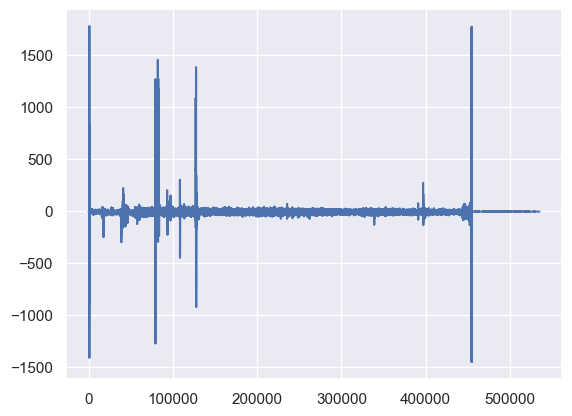

In [7]:
# For EEG data before VMD

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = E78_copy  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
new_data = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(new_data))
plt.plot(new_data)
plt.show()


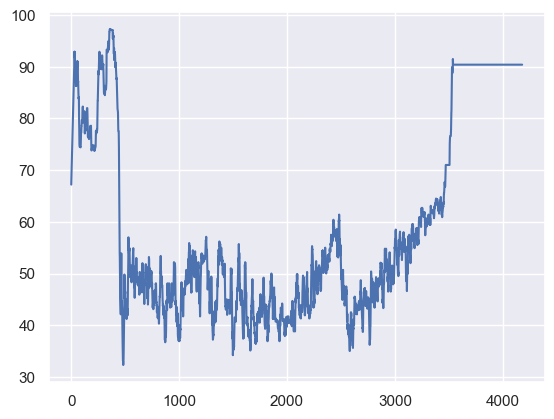

In [6]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = B78
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)

### Selecting EEG signals

In [6]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 60
bis_end_index = 3000

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-15.6   -9.35  -6.9  ... -13.25 -15.   -15.35]


### Bandpass filtering

In [9]:
# Define the EEG signal
eeg_signal = new_data # Replace with your actual EEG signal
fs=128

# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs)


### Variational Mode Decomposition (VMD)

In [10]:
signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

MemoryError: Unable to allocate 7.97 GiB for an array with shape (500, 1070272) and data type complex128

### Windowing and features extraction

Number of BIS: 2885


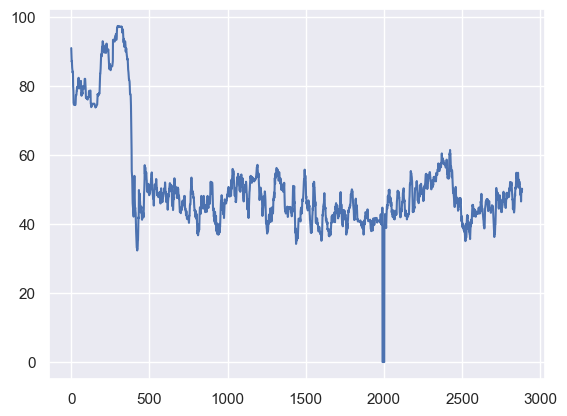

In [9]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [ ]:
# For mean and standard deviation

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    windows = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        windows.append(window)
        #window_start += stride
        
        
        if method == "mean":
            # Calculate sample entropy within the window
            results = np.mean(windows, axis=1)
            


        if method == "std":
            # Calculate sample entropy within the window
            results = np.std(windows, axis=1)

    return results

In [ ]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
print(f"Number of features:", len(results_0))


# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_1))

# Example usage
data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_2))

# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_3))

# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_4))

In [ ]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
print(f"Number of features:", len(result_0))


# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_1))

data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds  
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_2))

# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_3))

# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_4))


In [135]:
#### For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            sample_entropy = ant.sample_entropy(window)
            result.append(sample_entropy)
            
        if method == "spectral entropy":
            # Calculate sample entropy within the window
            sf=128
            spectral_entropy = ant.spectral_entropy(window, sf)
            result.append(spectral_entropy)
            
            
        if method == "lzc":
            # Calculate sample entropy within the window
            lzc_entropy = ant.lziv_complexity(window)
            result.append(lzc_entropy)
            
        if method == "svd":
            # Calculate sample entropy within the window
            svd_entropy = ant.svd_entropy(window)
            result.append(svd_entropy)
            
        if method == "dispm":
            # Calculate dispersion_entropy_multiscale_refined within the window
            disp_m, prob = sp.dispersion_entropy_multiscale_refined(window,classes=2, emb_dim=3, delay=1,return_all=False)
            result.append(disp_m)

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=2, scale=4, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "fuzzy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window, m=3, r=0.5, Fx='gudermannian')
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
            
            # Higuchi Fractal Dimension
        if method == "hfd":
            hfd = ant.higuchi_fd(window)
            result.append(hfd)
          
            # # Katz Fractal Dimension
        if method == "kfd":
            kfd = ant.katz_fd(window)
            result.append(kfd)
            
    
        
    return result


In [136]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdispm_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='dispm')
resultsdispm_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='dispm')
resultsdispm_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='dispm')
resultsdispm_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='dispm')
resultsdispm_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='dispm')
print(f"Number of features:", len(resultsdispm_1))

Number of features: 2885


In [99]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultspec_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='spectral entropy')
resultspec_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='spectral entropy')
resultspec_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='spectral entropy')
resultspec_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='spectral entropy')
resultspec_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='spectral entropy')
print(f"Number of features:", len(resultspec_1))

Number of features: 2885


In [96]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsvd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='svd')
resultsvd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='svd')
resultsvd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='svd')
resultsvd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='svd')
resultsvd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='svd')
print(f"Number of features:", len(resultsvd_1))

Number of features: 2885


In [94]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultslzc_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='lzc')
resultslzc_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='lzc')
resultslzc_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='lzc')
resultslzc_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='lzc')
resultslzc_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='lzc')
print(f"Number of features:", len(resultslzc_1))

Number of features: 2885


In [90]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultskfd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='kfd')
resultskfd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='kfd')
resultskfd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='kfd')
resultskfd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='kfd')
resultskfd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='kfd')
print(f"Number of features:", len(resultskfd_1))

Number of features: 2885


In [91]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshfd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hfd')
resultshfd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hfd')
resultshfd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hfd')
resultshfd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hfd')
resultshfd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hfd')
print(f"Number of features:", len(resultshfd_0))

Number of features: 2885


In [131]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsa_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
print(f"Number of features:", len(resultsa_0))

TypeError: argument of type 'builtin_function_or_method' is not iterable

In [11]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdt_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 2885


In [12]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultspet_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 2885


In [13]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshm_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 2885


In [14]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshc_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 2885


In [15]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 2885


In [16]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 2885


### Create Dataframe for each feature and find the correlation


In [140]:
# lzc

df_lzc = pd.DataFrame({'lzc_mode0': resultslzc_0, 'lzc_mode1': resultslzc_1, 'lzc_mode2': resultslzc_2, 'lzc_mode3': resultslzc_3, 'lzc_mode4': resultslzc_4})

df_lzc['BIS']=bis_windows
df_lzc

lzc_mode0  lzc_mode1  lzc_mode2  lzc_mode3  lzc_mode4   BIS
0           497        503        559        613        615  90.9
1           502        502        559        625        611  89.3
2           501        510        554        629        619  88.1
3           503        506        551        634        616  87.0
4           501        506        553        645        616  87.2
...         ...        ...        ...        ...        ...   ...
2880        590        706       1187        997        113  49.9
2881        591        704       1171       1001        115  49.2
2882        592        718       1163        998        116  50.2
2883        594        710       1160        999        112  49.9
2884        604        712       1151        994        112  50.1

[2885 rows x 6 columns]

In [139]:
# svd

df_svd = pd.DataFrame({'svd_mode0': resultsvd_0, 'svd_mode1': resultsvd_1, 'svd_mode2': resultsvd_2, 'svd_mode3': resultsvd_3, 'svd_mode4': resultsvd_4})

df_svd['BIS']=bis_windows
df_svd

svd_mode0  svd_mode1  svd_mode2  svd_mode3  svd_mode4   BIS
0      0.187200   0.685986   1.024224   1.191543   1.337459  90.9
1      0.188424   0.683948   1.025030   1.188992   1.337395  89.3
2      0.187118   0.684274   1.026118   1.188274   1.337863  88.1
3      0.191626   0.683303   1.026263   1.186534   1.338176  87.0
4      0.191821   0.683726   1.027101   1.185851   1.339149  87.2
...         ...        ...        ...        ...        ...   ...
2880   0.208286   0.698591   0.992738   1.133689   1.330943  49.9
2881   0.208269   0.699548   0.994203   1.132751   1.330383  49.2
2882   0.208173   0.699794   0.993279   1.132560   1.330541  50.2
2883   0.207384   0.700425   0.994346   1.133324   1.330799  49.9
2884   0.207180   0.700352   0.993904   1.133847   1.330930  50.1

[2885 rows x 6 columns]

In [138]:
# spectral entropy

df_spec = pd.DataFrame({'spec_mode0': resultspec_0, 'spec_mode1': resultspec_1, 'spec_mode2': resultspec_2, 'spec_mode3': resultspec_3, 'spec_mode4': resultspec_4})

df_spec['BIS']=bis_windows
df_spec

spec_mode0  spec_mode1  spec_mode2  spec_mode3  spec_mode4   BIS
0       5.488776    7.714825    7.994459    8.092977    8.927045  90.9
1       5.492976    7.688226    8.001645    8.059747    8.914752  89.3
2       5.453025    7.697946    8.021905    8.057997    8.919732  88.1
3       5.474471    7.693197    8.006766    8.059371    8.940271  87.0
4       5.481761    7.700808    8.041006    8.020577    8.955168  87.2
...          ...         ...         ...         ...         ...   ...
2880    5.892987    7.787403    7.893118    7.938066    8.913937  49.9
2881    5.870230    7.781735    7.864232    7.880889    8.919934  49.2
2882    5.889539    7.793589    7.828093    7.871300    8.915675  50.2
2883    5.854471    7.810946    7.833440    7.864144    8.916540  49.9
2884    5.856254    7.809236    7.846561    7.878753    8.934711  50.1

[2885 rows x 6 columns]

In [137]:
# dispm

df_dispm = pd.DataFrame({'dispm_mode0': resultsdispm_0, 'dispm_mode1': resultsdispm_1, 'dispm_mode2': resultsdispm_2, 'dispm_mode3': resultsdispm_3, 'dispm_mode4': resultsdispm_4})

df_dispm['BIS']=bis_windows
df_dispm

dispm_mode0  dispm_mode1  dispm_mode2  dispm_mode3  dispm_mode4   BIS
0        0.912794     1.500003     1.969982     2.068813     1.989963  90.9
1        0.902243     1.498699     1.969987     2.068326     1.988592  89.3
2        0.889199     1.500349     1.971416     2.068387     1.990634  88.1
3        0.885568     1.498093     1.971642     2.068478     1.990493  87.0
4        0.885560     1.496938     1.972760     2.068179     1.990275  87.2
...           ...          ...          ...          ...          ...   ...
2880     0.938838     1.536853     1.993522     2.070161     1.988855  49.9
2881     0.945258     1.542971     1.994002     2.070281     1.988677  49.2
2882     0.947475     1.539923     1.992585     2.069963     1.986979  50.2
2883     0.942939     1.544273     1.995574     2.070282     1.988490  49.9
2884     0.938303     1.543766     1.992772     2.070152     1.988887  50.1

[2885 rows x 6 columns]

In [133]:
# kfd

df_kfd = pd.DataFrame({'kfd_mode0': resultskfd_0, 'kfd_mode1': resultskfd_1, 'kfd_mode2': resultskfd_2, 'kfd_mode3': resultskfd_3, 'kfd_mode4': resultskfd_4})

df_kfd['BIS']=bis_windows
df_kfd

kfd_mode0  kfd_mode1  kfd_mode2  kfd_mode3  kfd_mode4   BIS
0      1.802952   2.842789   3.453663   3.839312   5.645294  90.9
1      1.832914   2.800837   3.138748   4.418961   6.747271  89.3
2      1.678553   2.551799   3.459122   4.394938   7.232870  88.1
3      1.728850   2.866398   3.294580   4.440014   6.268862  87.0
4      1.648153   2.756279   3.153514   4.596045   6.090689  87.2
...         ...        ...        ...        ...        ...   ...
2880   1.770648   2.659938   3.722745   4.278922   4.926879  49.9
2881   1.845784   2.681855   3.787574   4.128750   5.535580  49.2
2882   1.848002   2.517450   3.504127   4.256111   4.693178  50.2
2883   1.832978   2.663367   3.767183   3.975482   5.433026  49.9
2884   1.834439   2.639024   3.348916   3.901334   5.233230  50.1

[2885 rows x 6 columns]

In [132]:
# hfd

df_hfd = pd.DataFrame({'hfd_mode0': resultshfd_0, 'hfd_mode1': resultshfd_1, 'hfd_mode2': resultshfd_2, 'hfd_mode3': resultshfd_3, 'hfd_mode4': resultshfd_4})

df_hfd['BIS']=bis_windows
df_hfd

hfd_mode0  hfd_mode1  hfd_mode2  hfd_mode3  hfd_mode4   BIS
0      1.032447   1.108758   1.543205   1.993183   2.047469  90.9
1      1.030913   1.106896   1.542990   1.994837   2.046800  89.3
2      1.031719   1.106413   1.546028   1.994889   2.046751  88.1
3      1.030504   1.105397   1.546193   1.997134   2.046621  87.0
4      1.032167   1.105787   1.550008   1.996681   2.047431  87.2
...         ...        ...        ...        ...        ...   ...
2880   1.045144   1.130440   1.611967   2.014978   2.047057  49.9
2881   1.044782   1.131199   1.609714   2.016289   2.047216  49.2
2882   1.043046   1.131558   1.607070   2.016533   2.047518  50.2
2883   1.042976   1.130985   1.609149   2.015794   2.048165  49.9
2884   1.043291   1.131781   1.606551   2.014614   2.047224  50.1

[2885 rows x 6 columns]

In [17]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


In [ ]:
# sample entropy

df_samp = pd.DataFrame({'samp_mode0': resultsa_0, 'samp_mode1': resultsa_1, 'samp_mode2': resultsa_2, 'samp_mode3': resultsa_3, 'samp_mode4': resultsa_4})

df_samp['BIS']=bis_windows
df_samp


In [18]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet



In [19]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [20]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


In [21]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [22]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

### Save the extracted data in csv

In [47]:
df_detf.to_csv('detf_78.csv' , index=False)
df_hm.to_csv('hm_78.csv', index=False)
df_hc.to_csv('hc_78.csv', index=False)
df_perm.to_csv('perm_78.csv', index=False)
df_pet.to_csv('pet_78.csv', index=False)
df_disp.to_csv('disp_78.csv', index=False)

In [141]:
df_lzc.to_csv('lzc_78.csv' , index=False)
df_kfd.to_csv('kfd_78.csv', index=False)
df_hfd.to_csv('hfd_78.csv', index=False)
df_spec.to_csv('spec_78.csv', index=False)
df_svd.to_csv('svd_78.csv', index=False)
df_dispm.to_csv('dispm_78.csv', index=False)
df_std.to_csv('std_78.csv', index=False)
df_mean.to_csv('mean_78.csv', index=False)

In [142]:
pd.read_csv('lzc_78.csv')

lzc_mode0  lzc_mode1  lzc_mode2  lzc_mode3  lzc_mode4   BIS
0           497        503        559        613        615  90.9
1           502        502        559        625        611  89.3
2           501        510        554        629        619  88.1
3           503        506        551        634        616  87.0
4           501        506        553        645        616  87.2
...         ...        ...        ...        ...        ...   ...
2880        590        706       1187        997        113  49.9
2881        591        704       1171       1001        115  49.2
2882        592        718       1163        998        116  50.2
2883        594        710       1160        999        112  49.9
2884        604        712       1151        994        112  50.1

[2885 rows x 6 columns]

### Visualize the extracted features

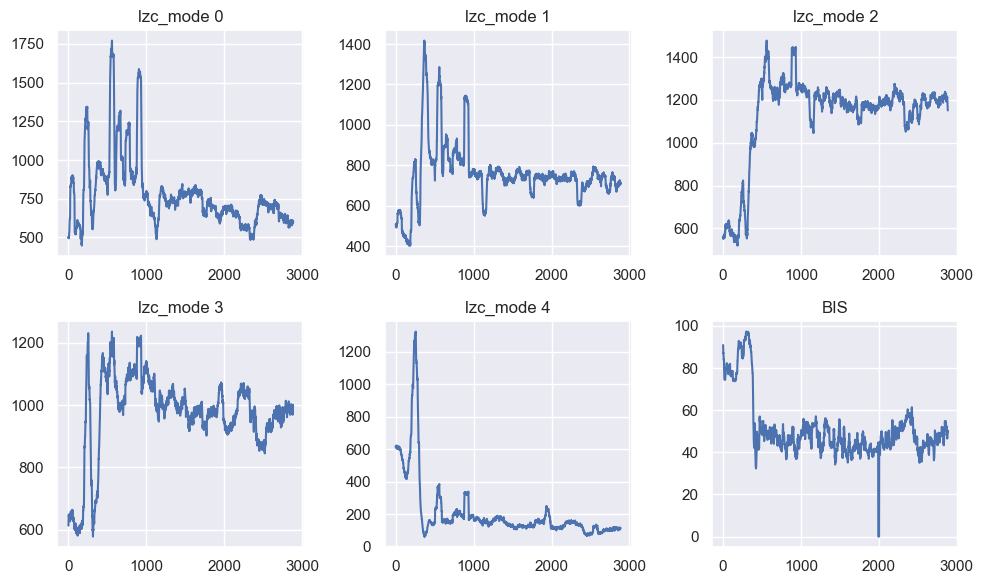

In [143]:
# Lzc


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultslzc_0)
axes[0, 0].set_title('lzc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultslzc_1)
axes[0, 1].set_title('lzc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultslzc_2)
axes[0, 2].set_title('lzc_mode 2')

axes[1, 0].plot(resultslzc_3)
axes[1, 0].set_title('lzc_mode 3')

axes[1, 1].plot(resultslzc_4)
axes[1, 1].set_title('lzc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()

ant.higuchi_fd

# Display the figure
plt.show()

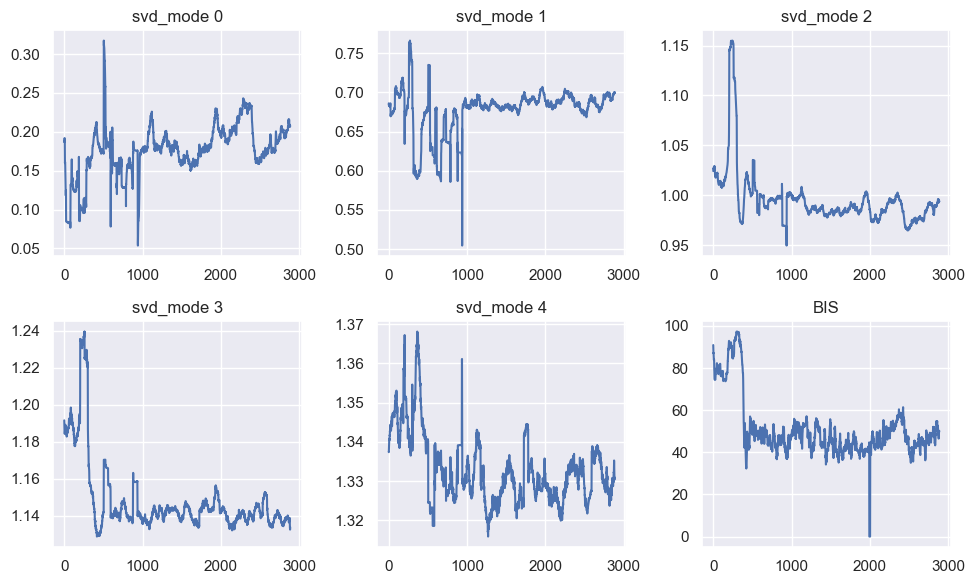

In [144]:
# svd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsvd_0)
axes[0, 0].set_title('svd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsvd_1)
axes[0, 1].set_title('svd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsvd_2)
axes[0, 2].set_title('svd_mode 2')

axes[1, 0].plot(resultsvd_3)
axes[1, 0].set_title('svd_mode 3')

axes[1, 1].plot(resultsvd_4)
axes[1, 1].set_title('svd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

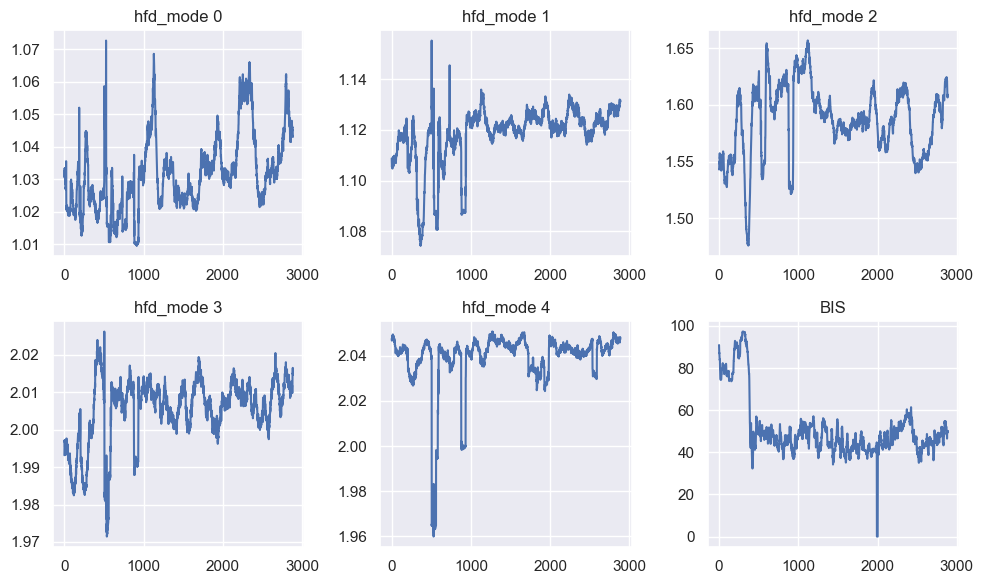

In [145]:
# hfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshfd_0)
axes[0, 0].set_title('hfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshfd_1)
axes[0, 1].set_title('hfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshfd_2)
axes[0, 2].set_title('hfd_mode 2')

axes[1, 0].plot(resultshfd_3)
axes[1, 0].set_title('hfd_mode 3')

axes[1, 1].plot(resultshfd_4)
axes[1, 1].set_title('hfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

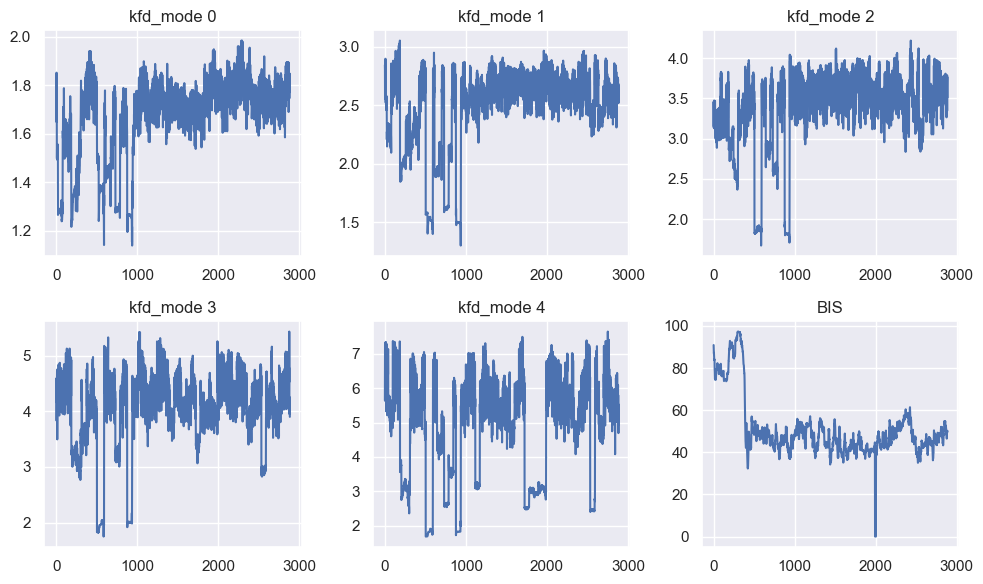

In [146]:
# kfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultskfd_0)
axes[0, 0].set_title('kfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultskfd_1)
axes[0, 1].set_title('kfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultskfd_2)
axes[0, 2].set_title('kfd_mode 2')

axes[1, 0].plot(resultskfd_3)
axes[1, 0].set_title('kfd_mode 3')

axes[1, 1].plot(resultskfd_4)
axes[1, 1].set_title('kfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

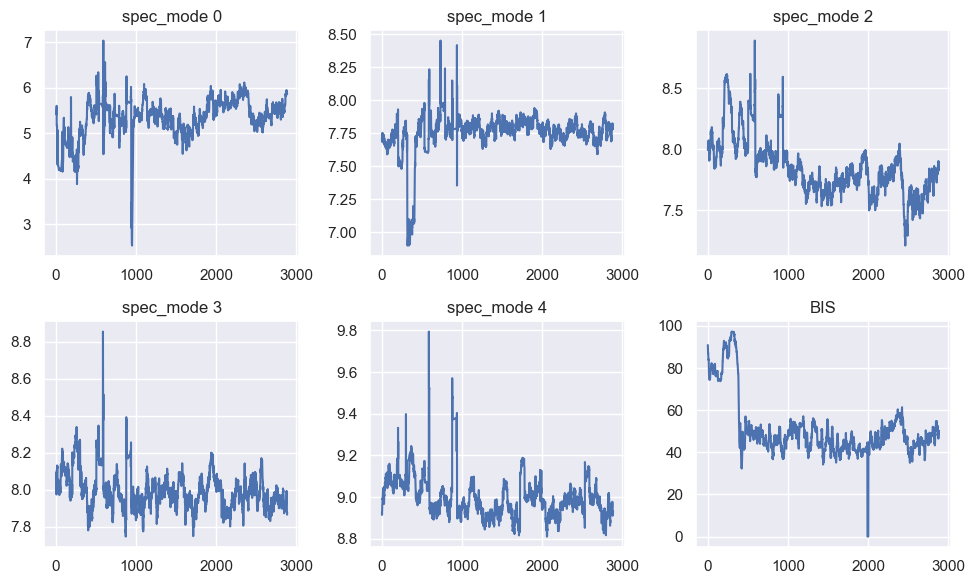

In [147]:
# spectral entropy


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspec_0)
axes[0, 0].set_title('spec_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspec_1)
axes[0, 1].set_title('spec_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspec_2)
axes[0, 2].set_title('spec_mode 2')

axes[1, 0].plot(resultspec_3)
axes[1, 0].set_title('spec_mode 3')

axes[1, 1].plot(resultspec_4)
axes[1, 1].set_title('spec_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

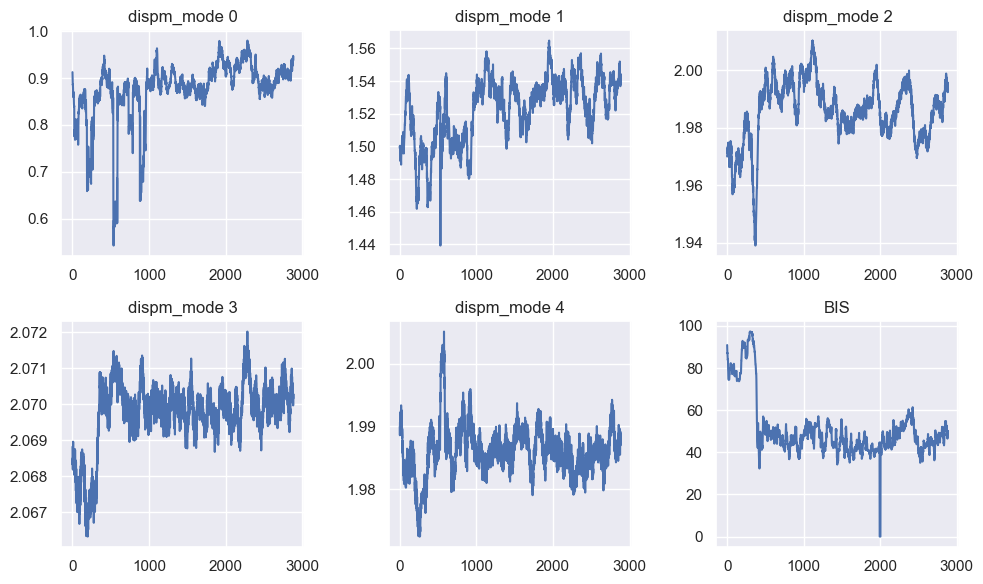

In [149]:
# dispm


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdispm_0)
axes[0, 0].set_title('dispm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdispm_1)
axes[0, 1].set_title('dispm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdispm_2)
axes[0, 2].set_title('dispm_mode 2')

axes[1, 0].plot(resultsdispm_3)
axes[1, 0].set_title('dispm_mode 3')

axes[1, 1].plot(resultsdispm_4)
axes[1, 1].set_title('dispm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [27]:
metrics = {}
def plot_regression(data, column):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    
    # Predictions
    y_predicted = reg.predict(X_test)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    
    # Plot the graph#
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="data", c="blue")
    plt.plot(X_test, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

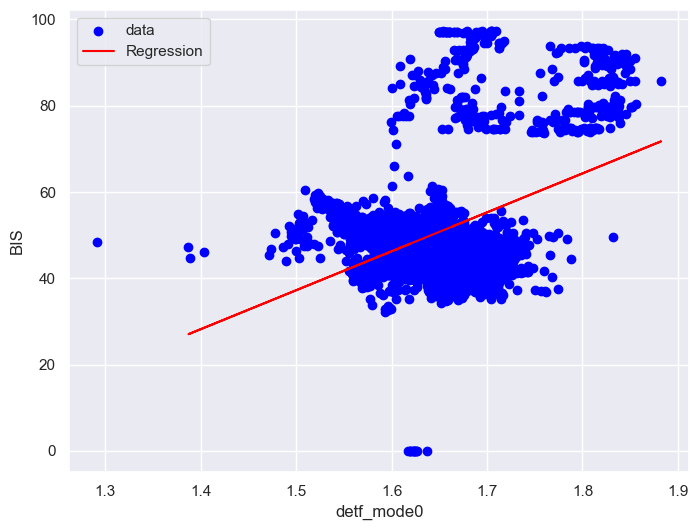

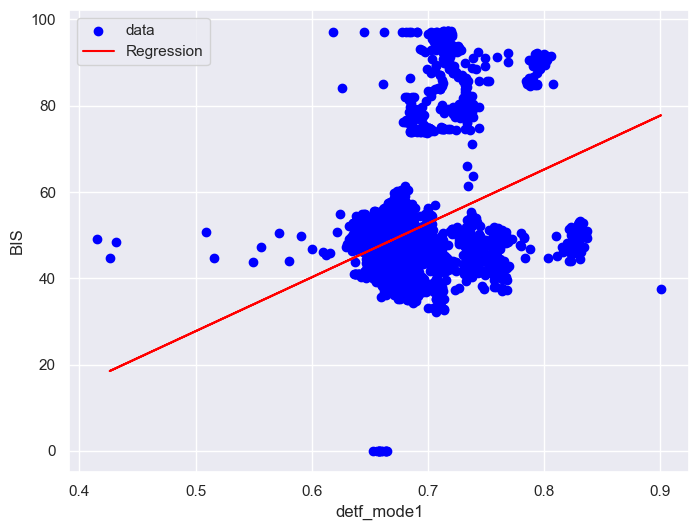

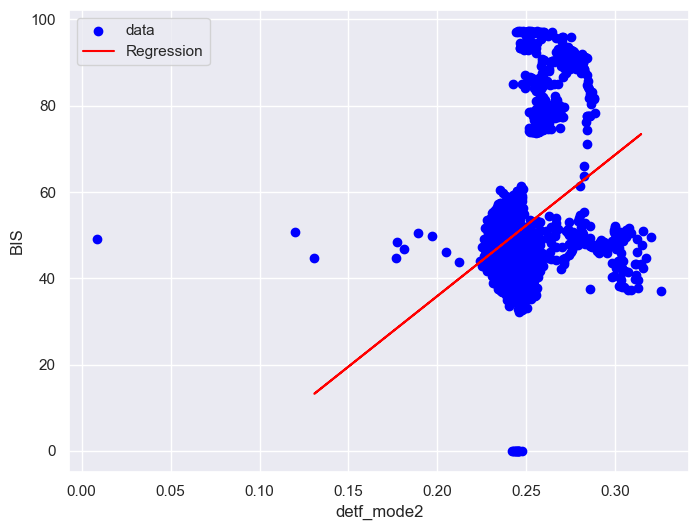

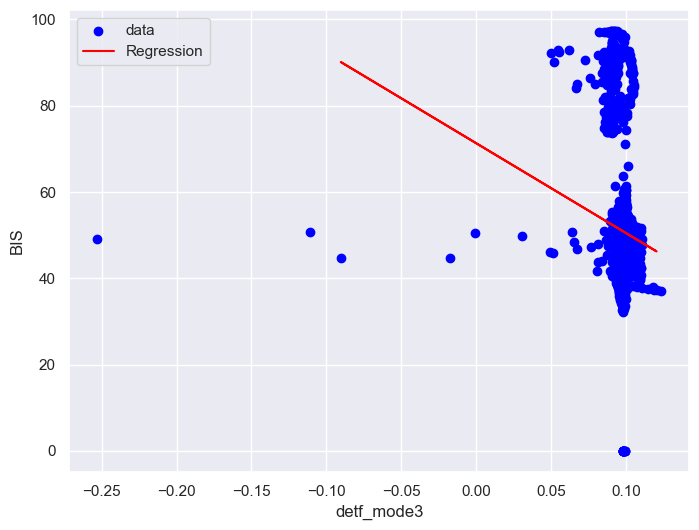

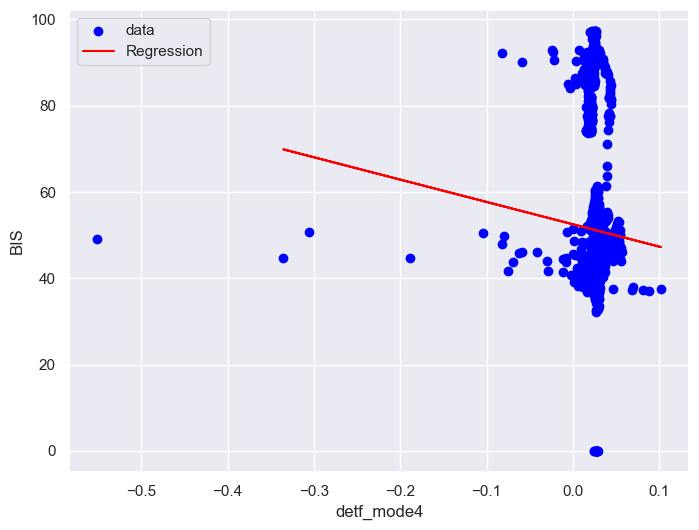

In [28]:
for column in df_detf.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_detf, column)

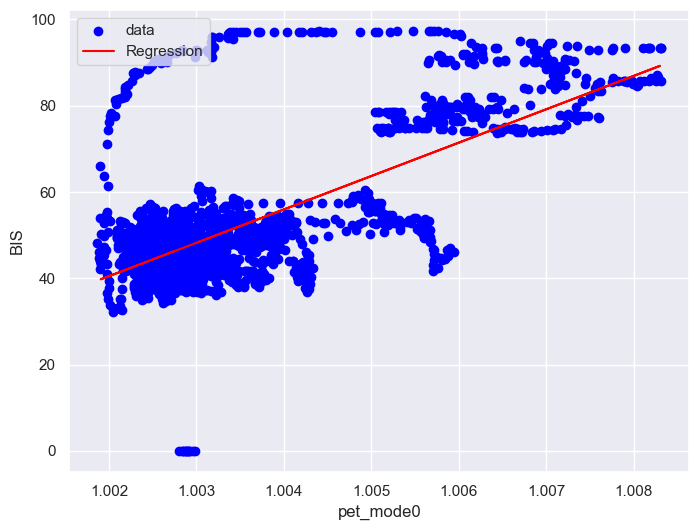

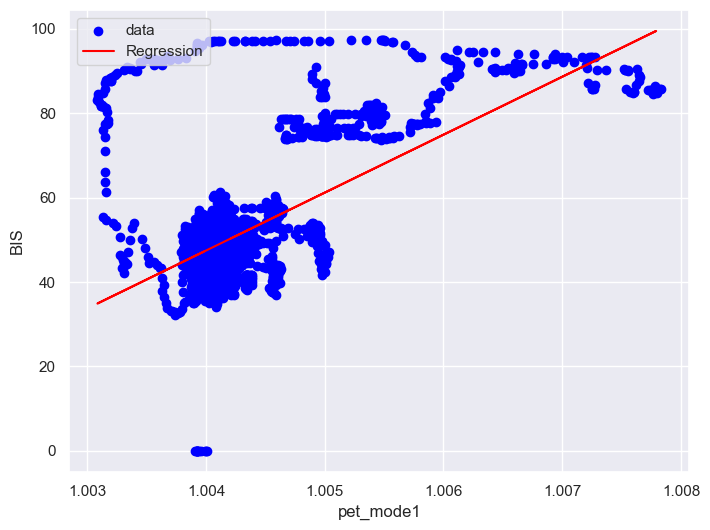

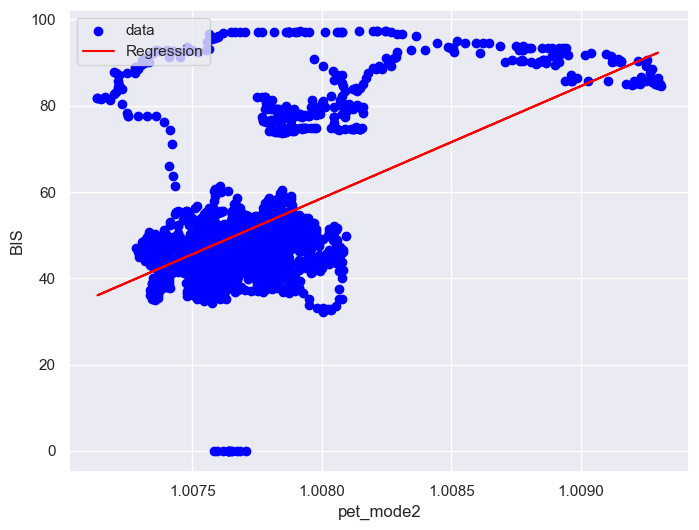

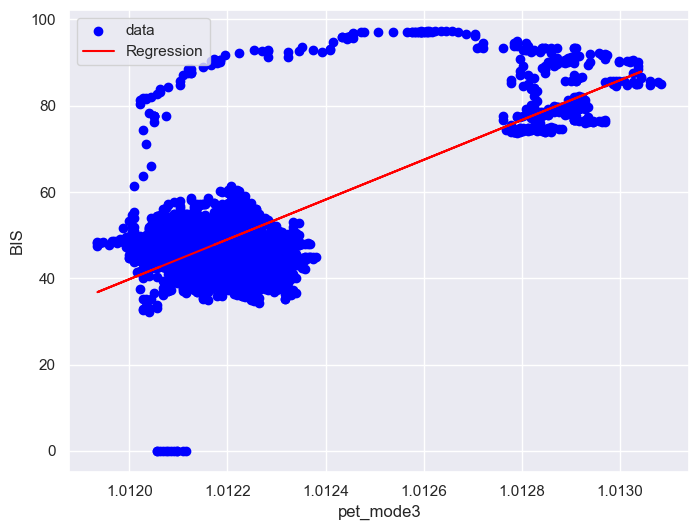

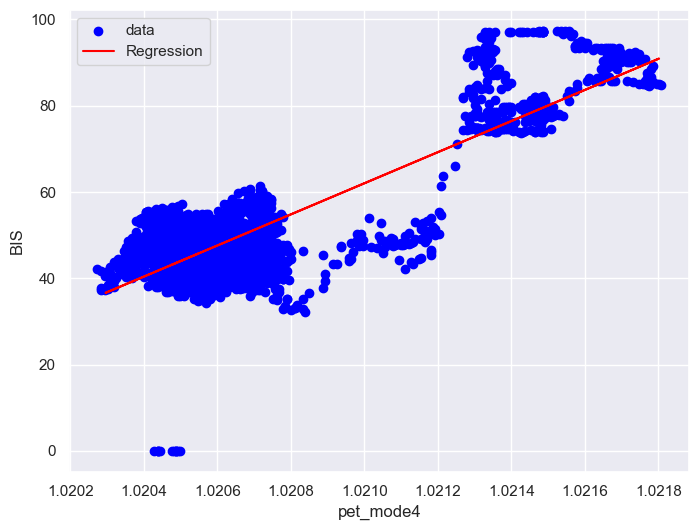

In [30]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

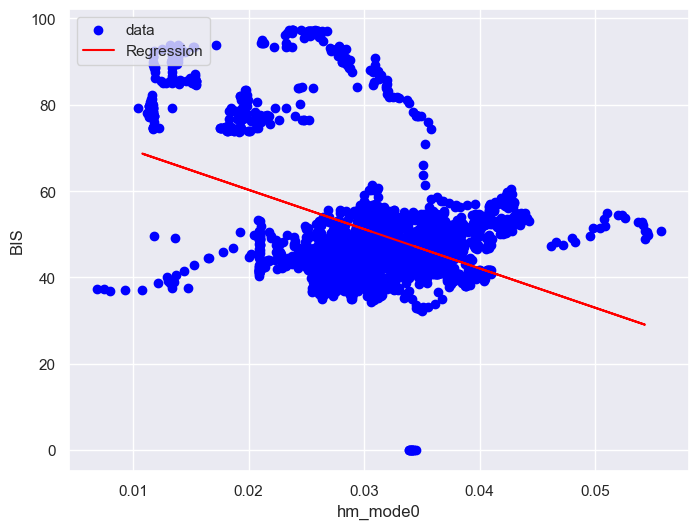

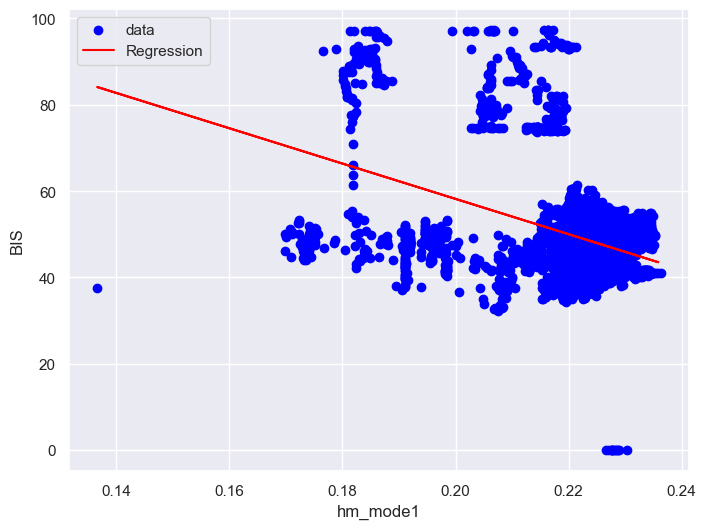

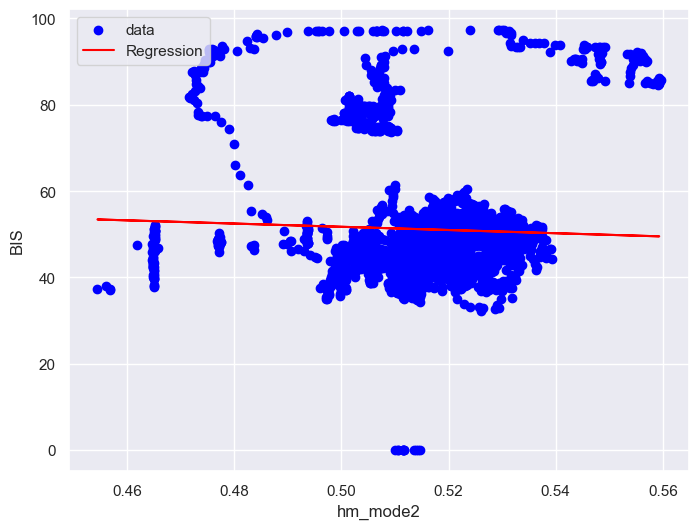

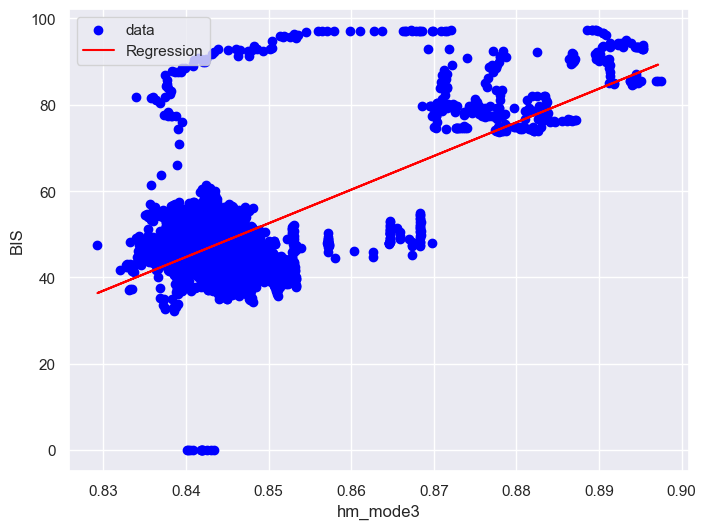

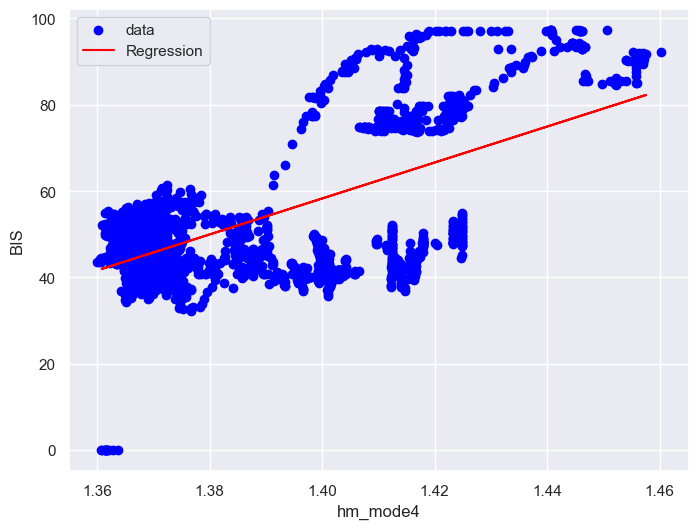

In [32]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

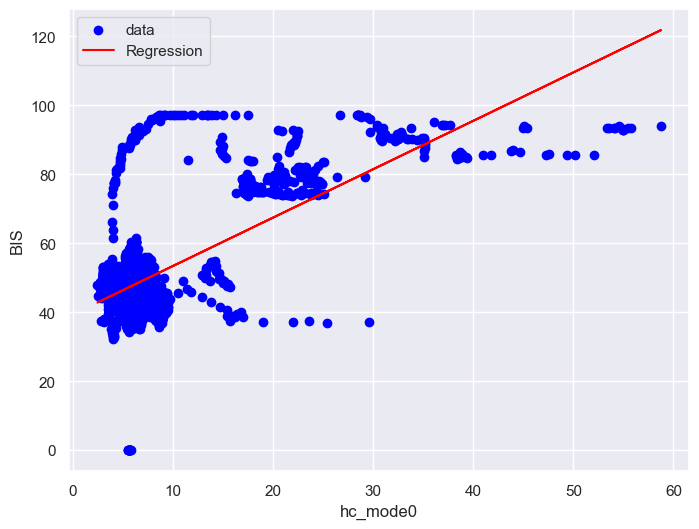

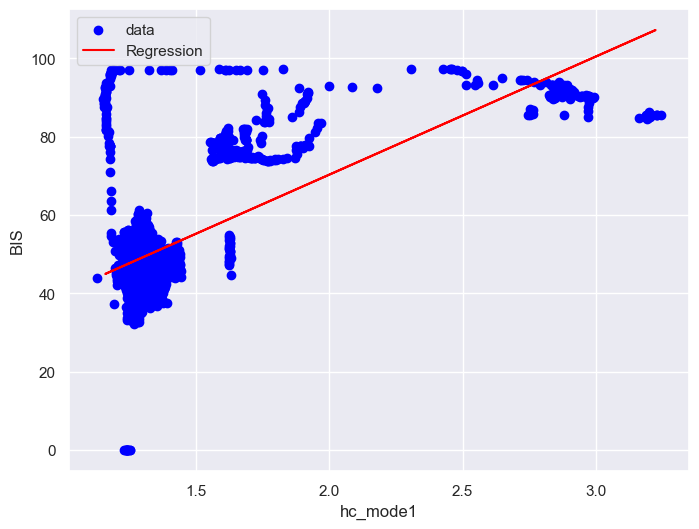

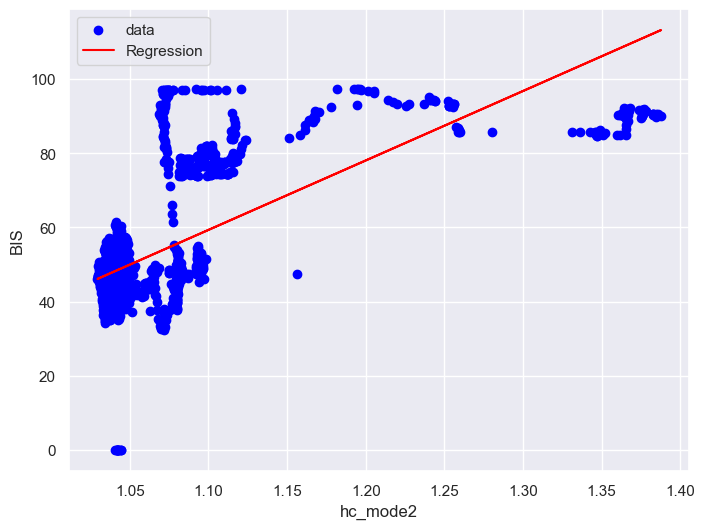

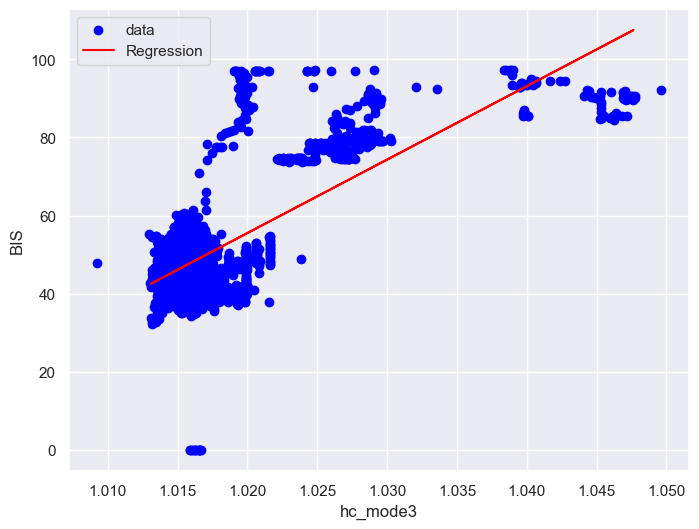

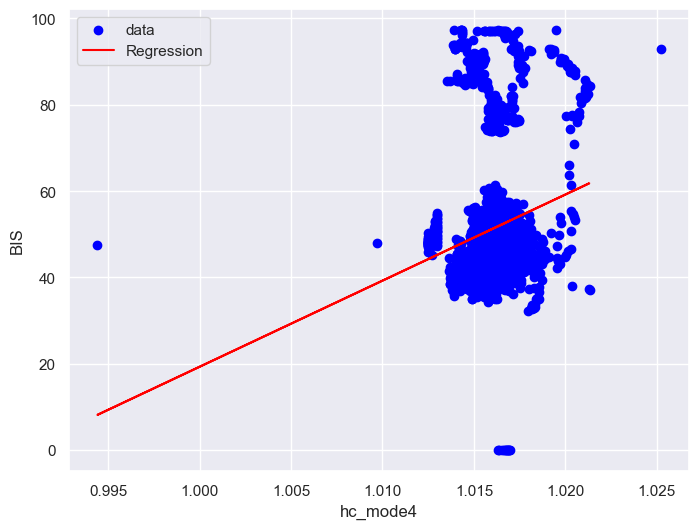

In [33]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

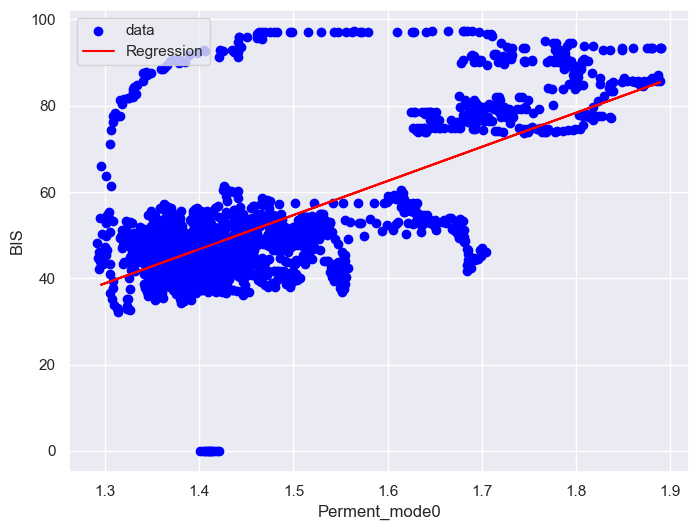

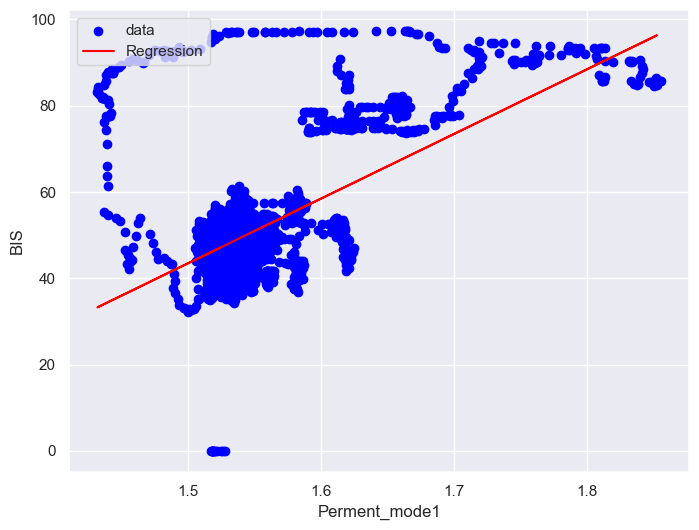

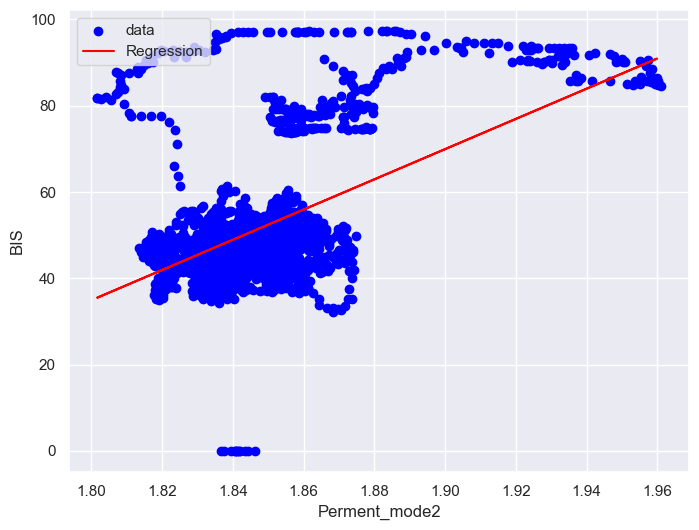

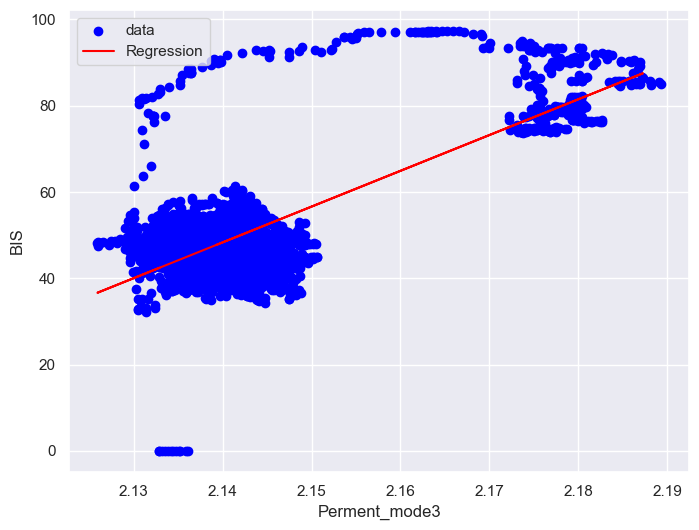

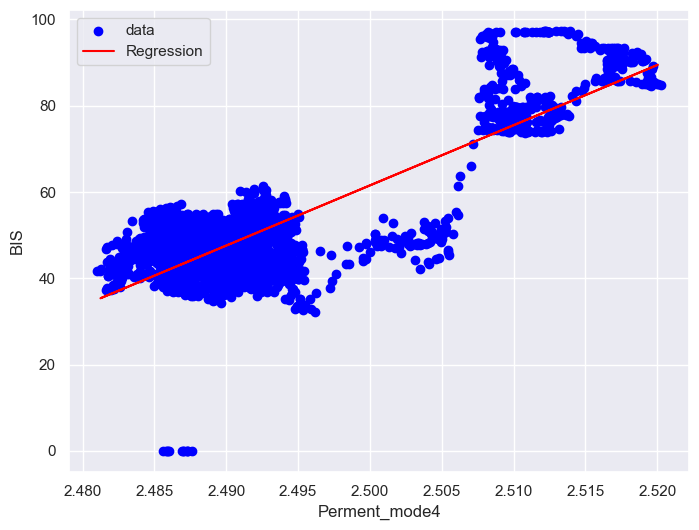

In [34]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

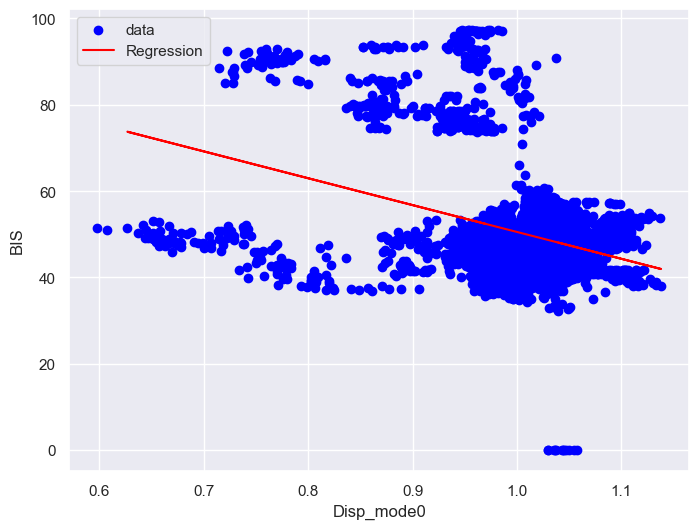

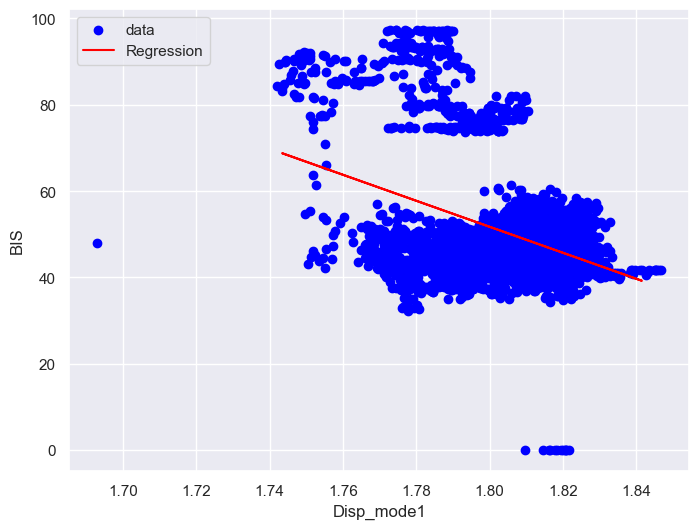

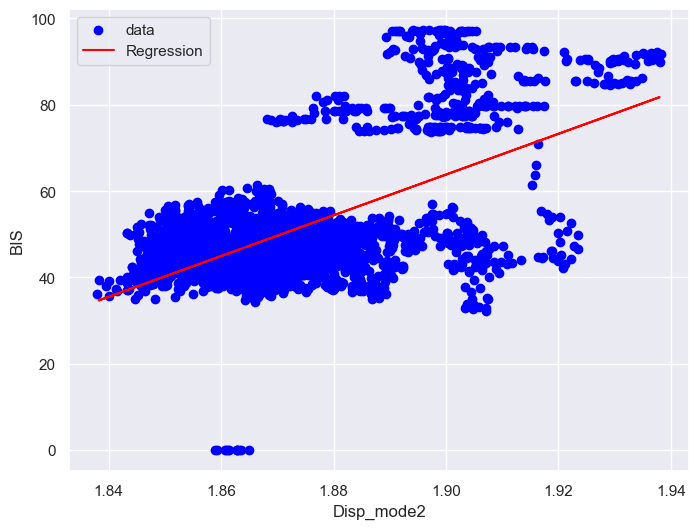

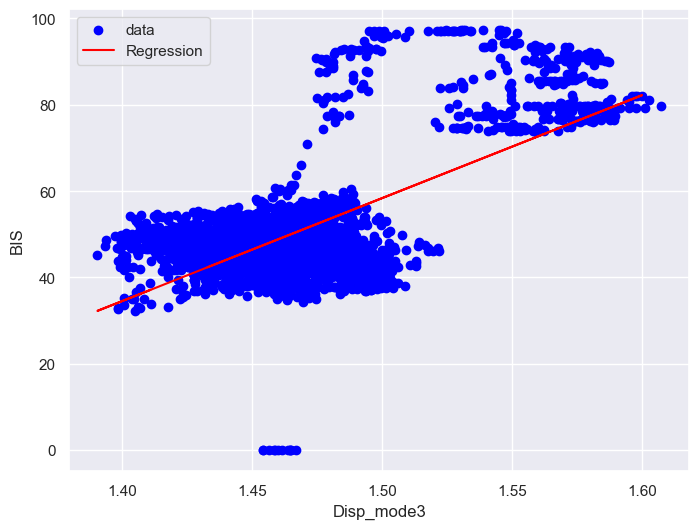

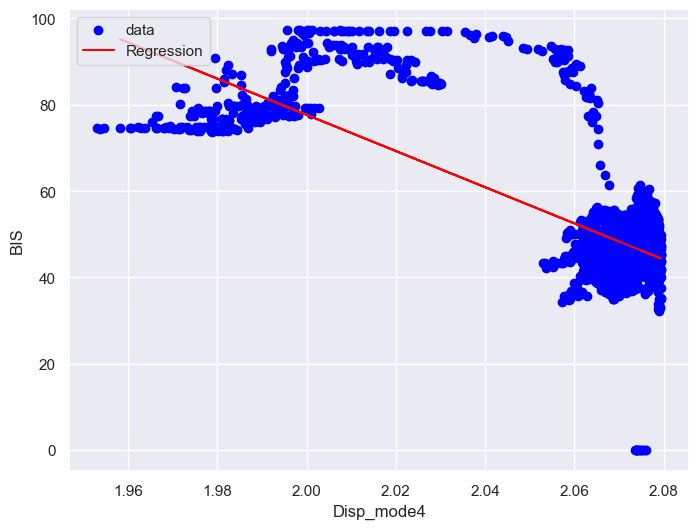

In [35]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

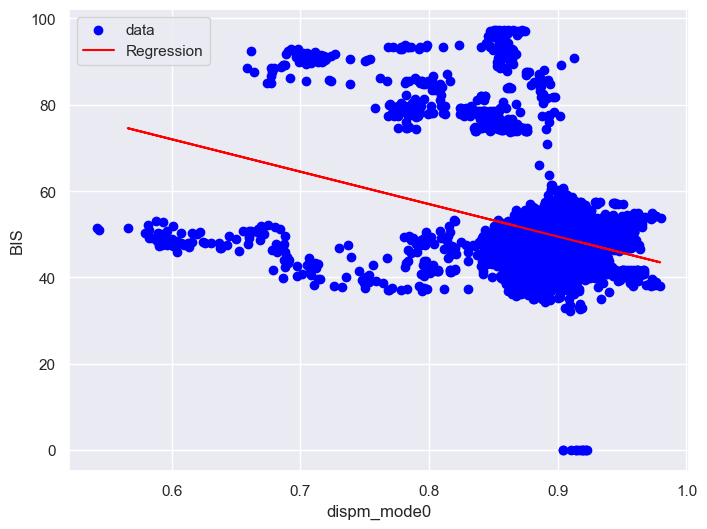

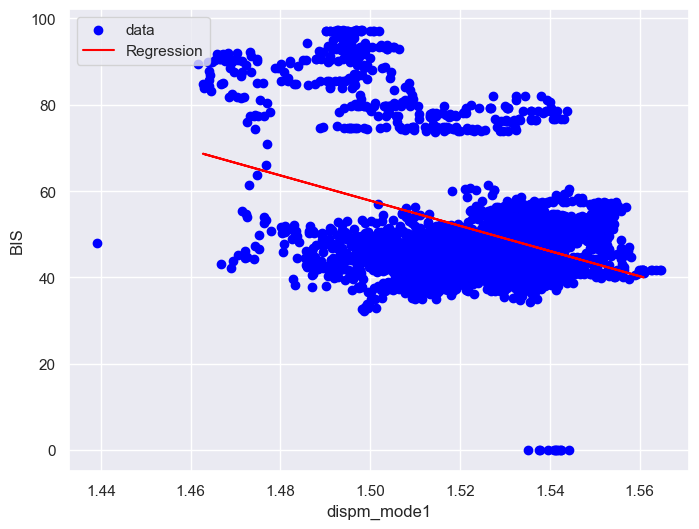

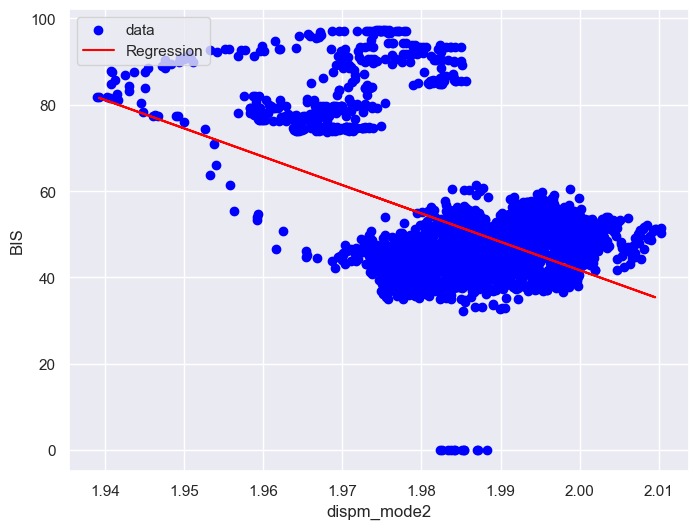

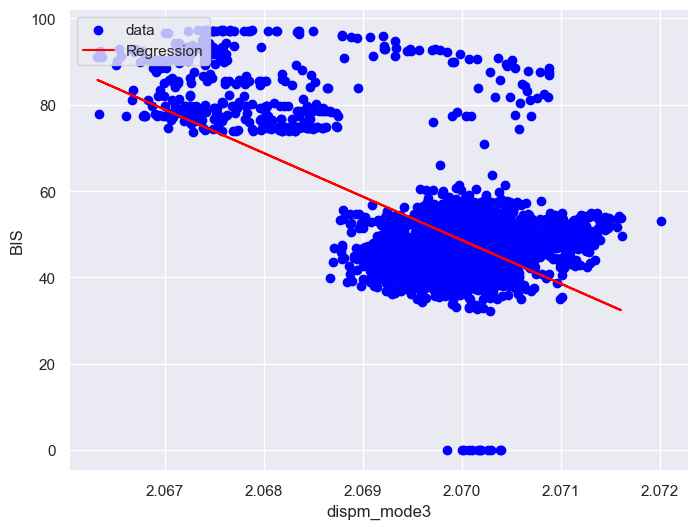

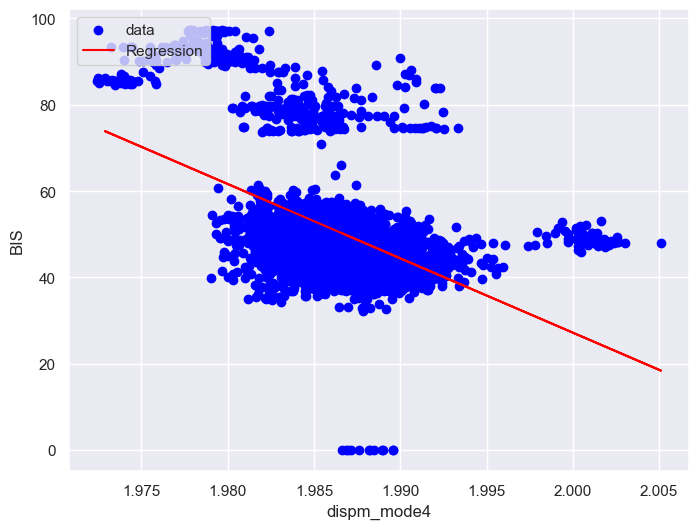

In [150]:
for column in df_dispm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_dispm, column)

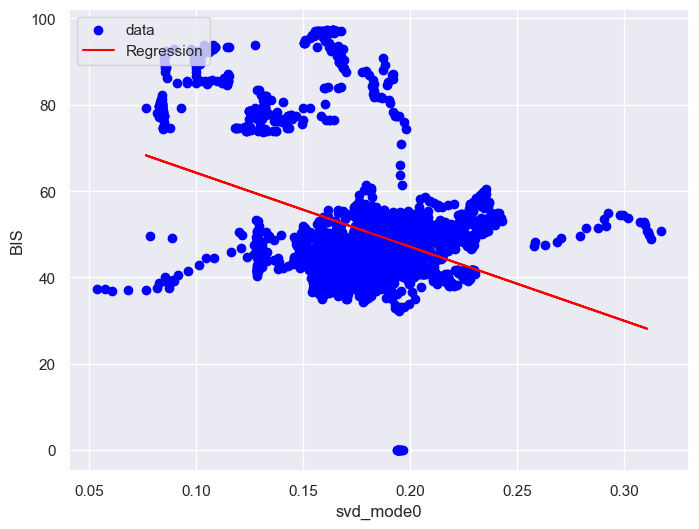

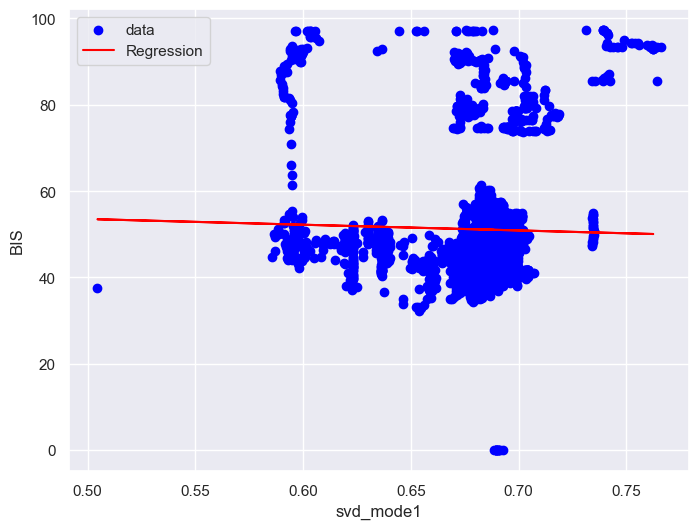

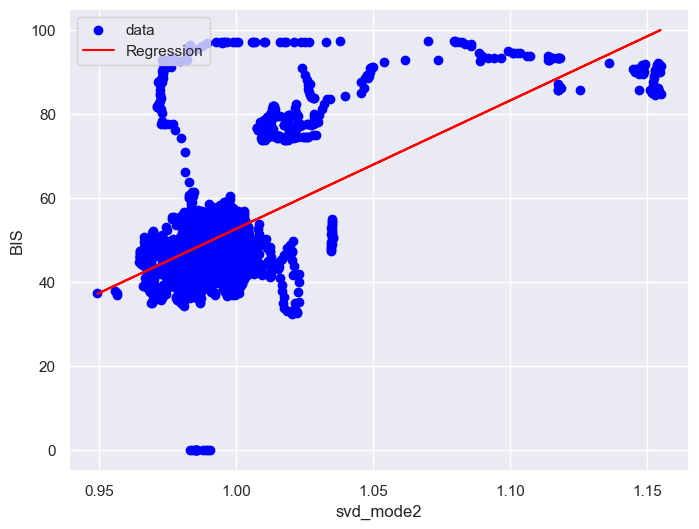

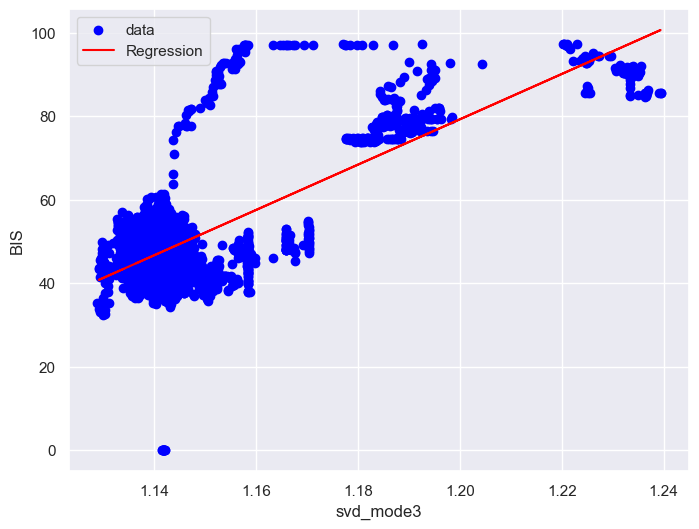

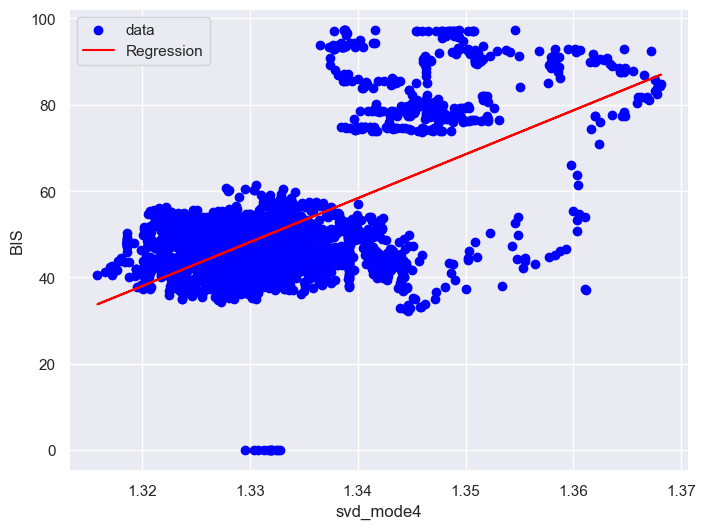

In [151]:
for column in df_svd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_svd, column)

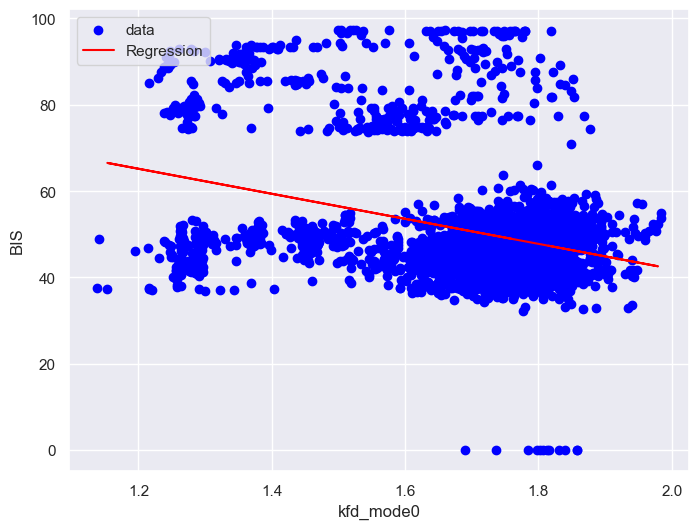

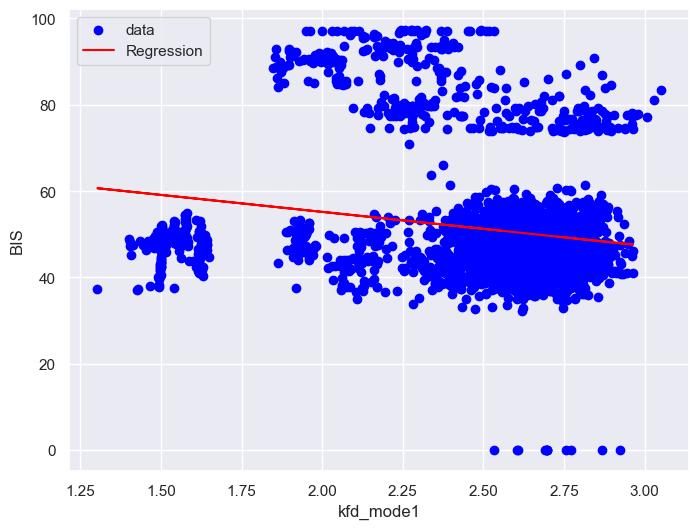

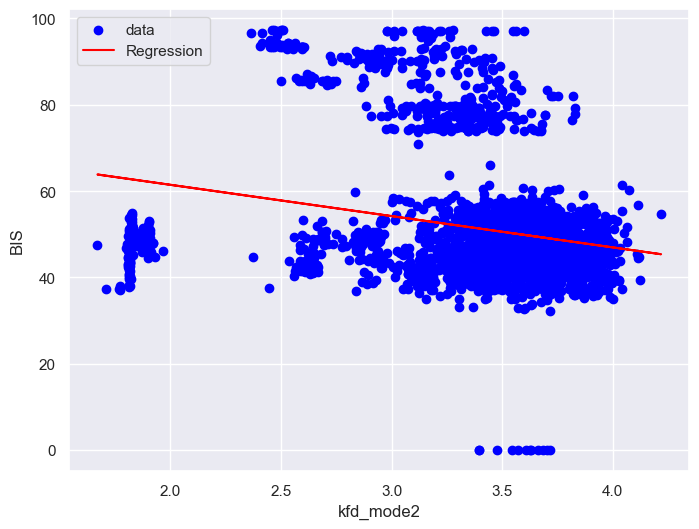

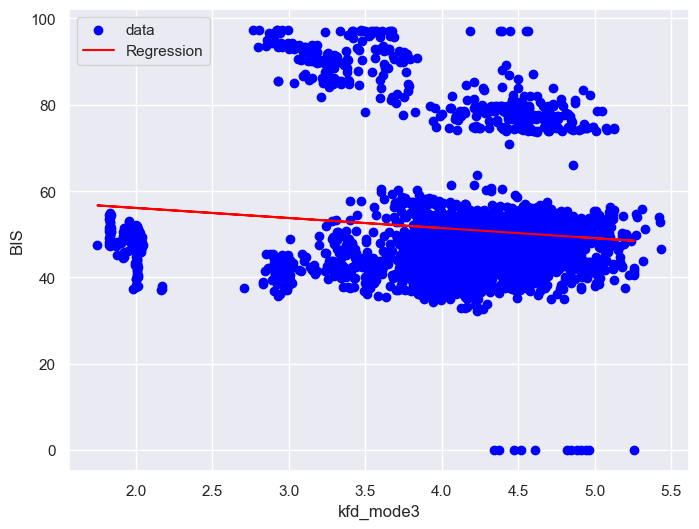

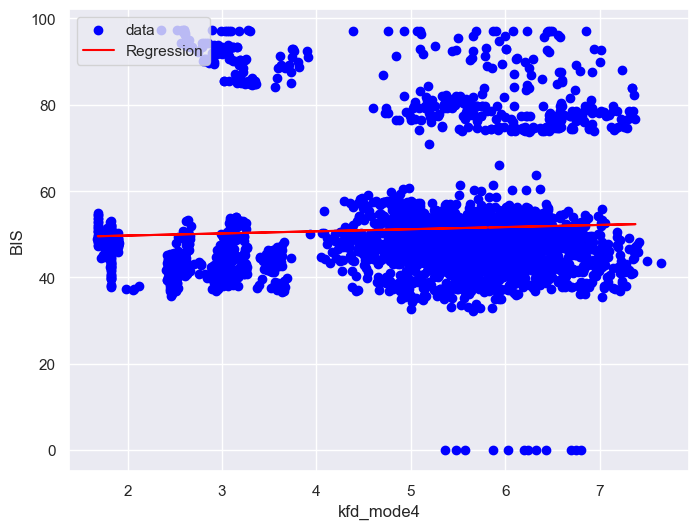

In [152]:
for column in df_kfd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_kfd, column)

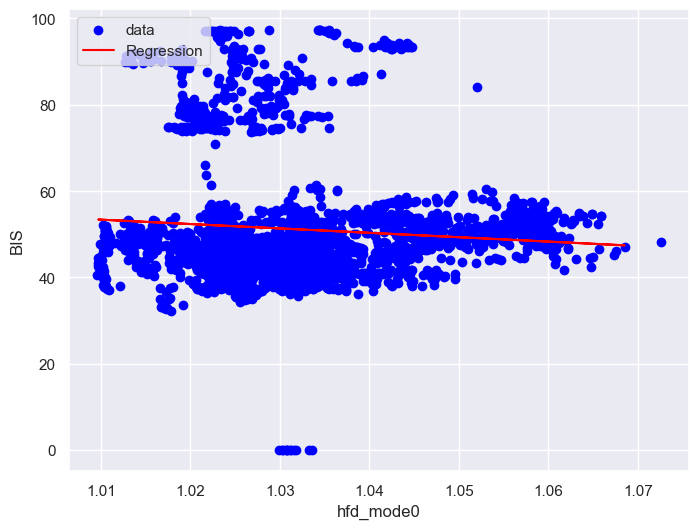

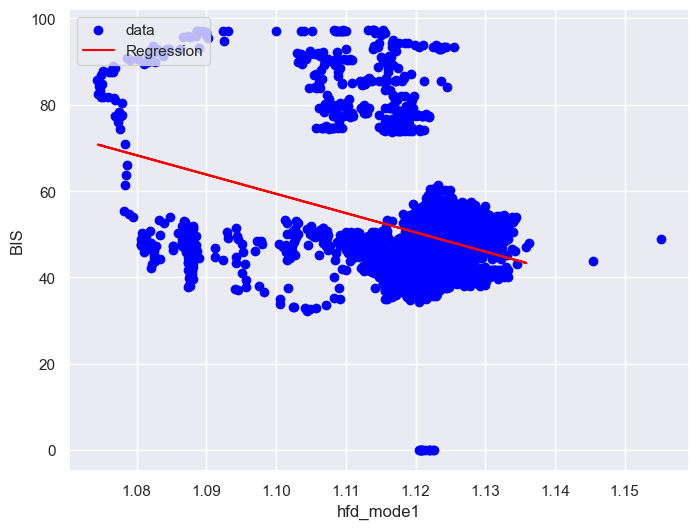

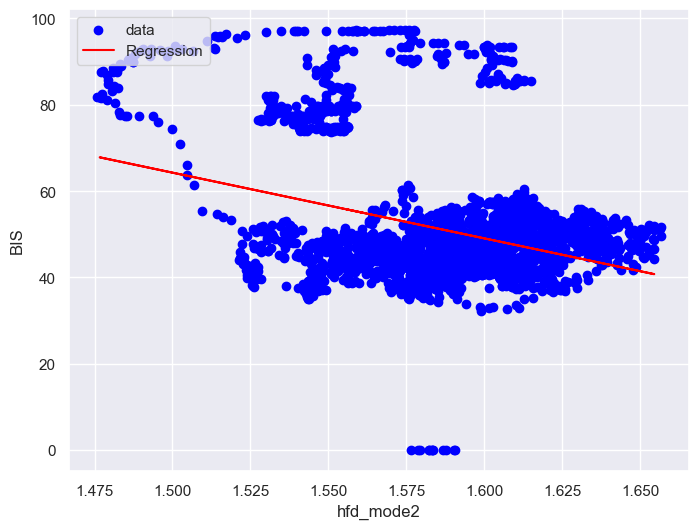

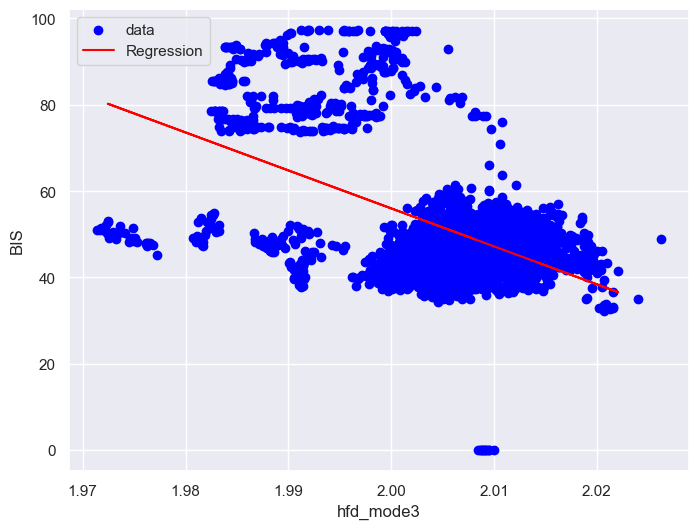

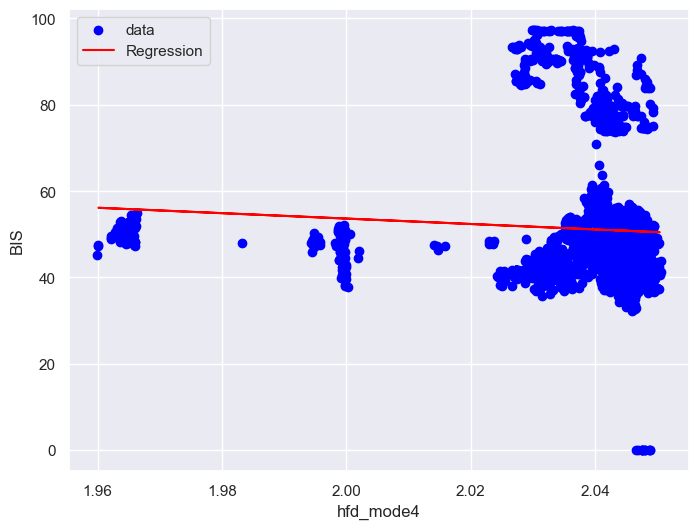

In [153]:
for column in df_hfd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hfd, column)

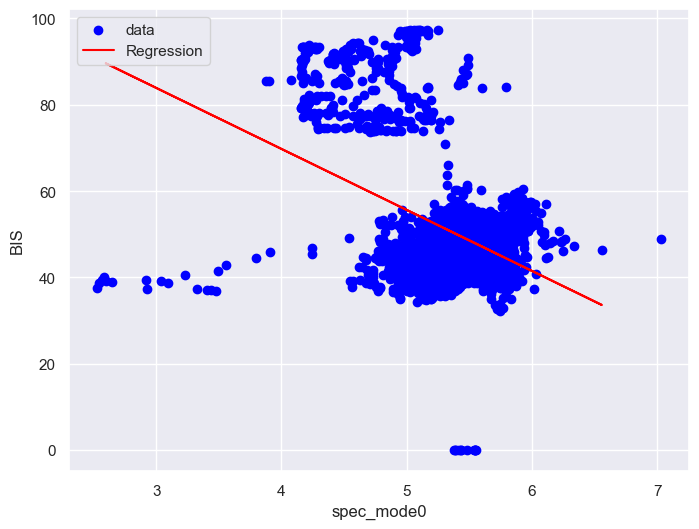

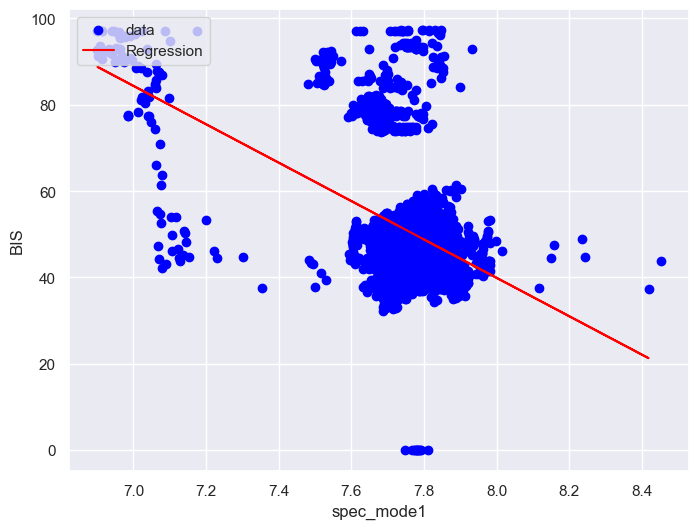

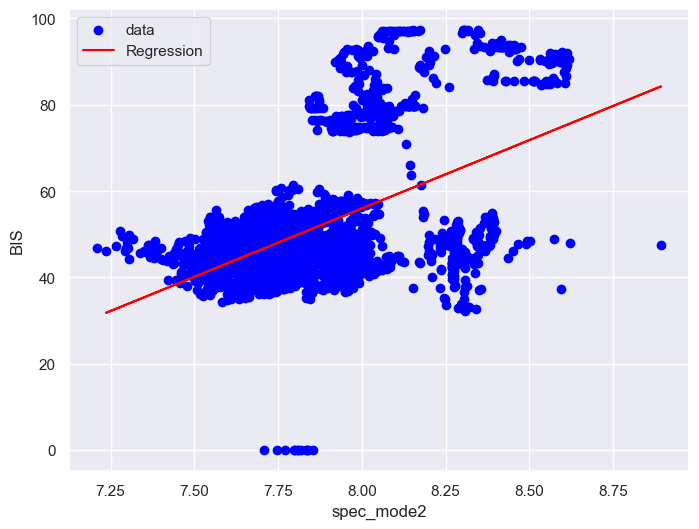

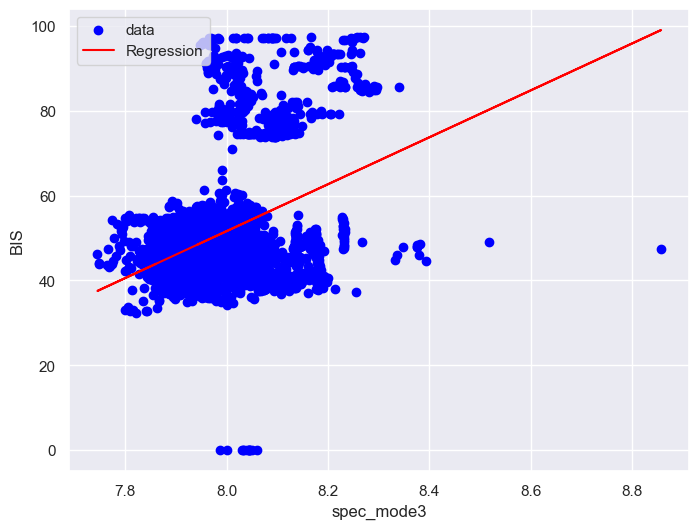

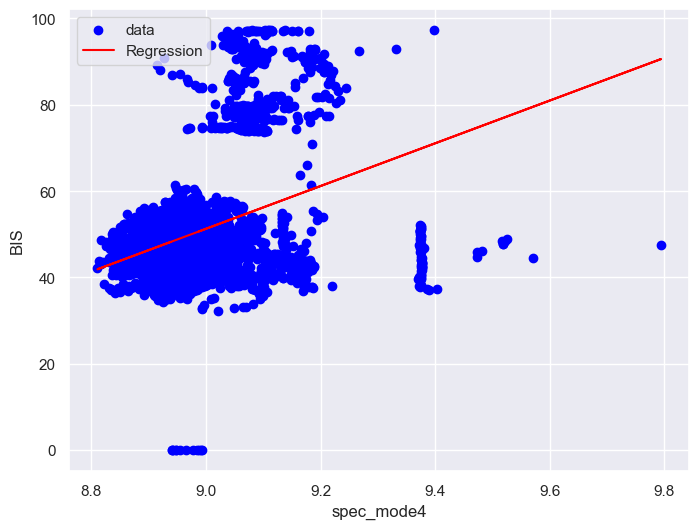

In [154]:
for column in df_spec.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_spec, column)

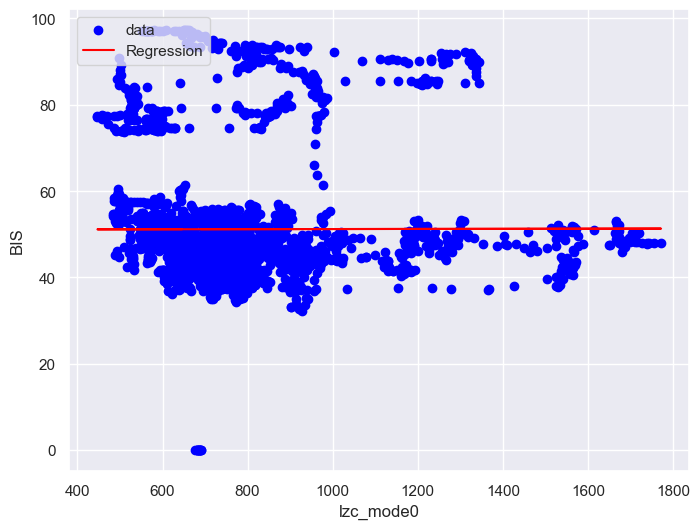

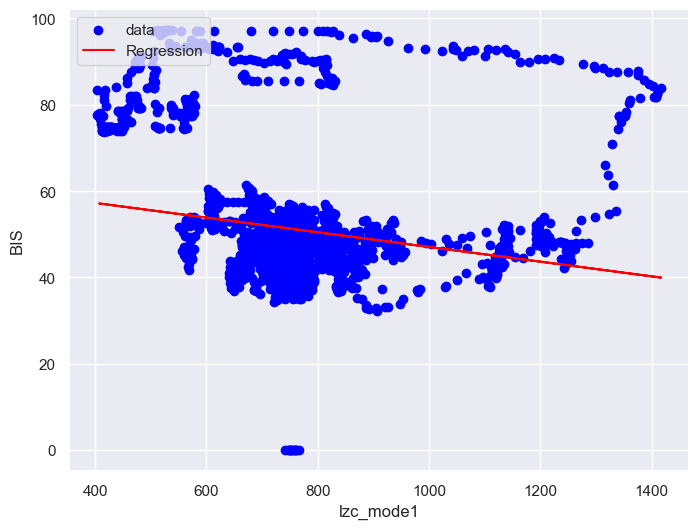

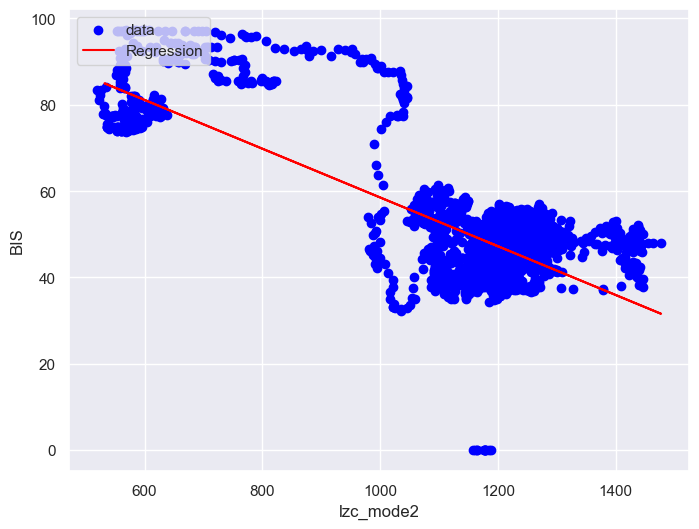

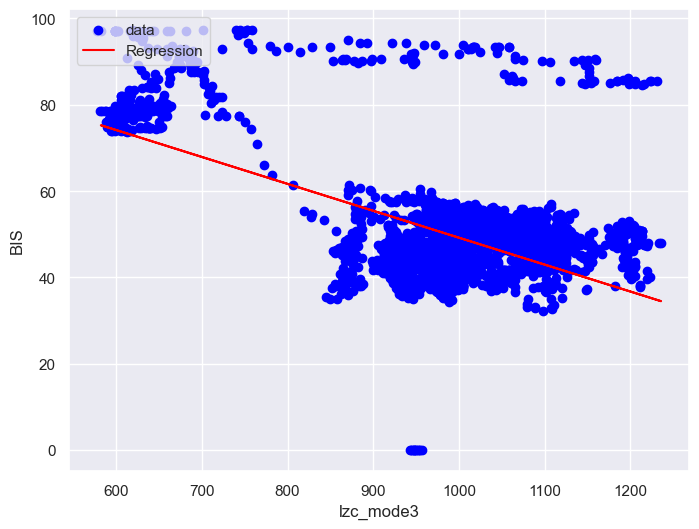

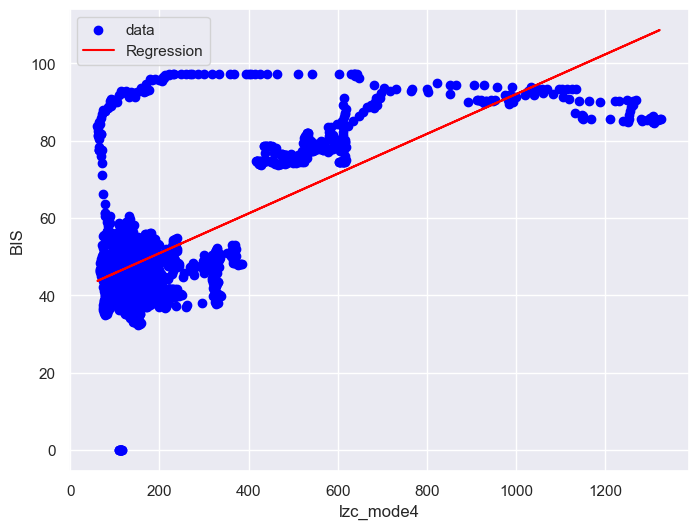

In [155]:
for column in df_lzc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_lzc, column)

In [156]:
# Metrics
total=pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})


In [157]:
sort_total=total.sort_values('Values', ascending=False)
sort_total

Metrics     Values
9       pet_mode4_r2  70.329059
24  Perment_mode4_r2  68.595439
57      lzc_mode2_r2  64.394240
38      svd_mode3_r2  61.387848
29     Disp_mode4_r2  60.572056
18       hc_mode3_r2  59.083945
8       pet_mode3_r2  58.145819
23  Perment_mode3_r2  58.053575
15       hc_mode0_r2  54.807503
59      lzc_mode4_r2  54.702734
5       pet_mode0_r2  53.757276
13       hm_mode3_r2  53.544080
20  Perment_mode0_r2  52.085338
16       hc_mode1_r2  49.426728
17       hc_mode2_r2  49.038369
28     Disp_mode3_r2  47.758075
6       pet_mode1_r2  47.092032
33    dispm_mode3_r2  46.927149
21  Perment_mode1_r2  46.604702
37      svd_mode2_r2  44.702549
14       hm_mode4_r2  43.813244
27     Disp_mode2_r2  36.694884
39      svd_mode4_r2  36.402918
7       pet_mode2_r2  35.357827
22  Perment_mode2_r2  35.061505
58      lzc_mode3_r2  29.057411
52     spec_mode2_r2  24.893316
48      hfd_mode3_r2  24.454870
10       hm_mode0_r2  22.928035
34    dispm_mode4_r2  22.286899
50     spec_mode0_r2  21.843293
32    dispm_mode2_r2  21.595409
51     spec_mode1_r2  18.973574
35      svd_mode0_r2  18.620962
0      detf_mode0_r2  18.455249
26     Disp_mode1_r2  17.448057
31    dispm_mode1_r2  16.986983
11       hm_mode1_r2  12.598724
40      kfd_mode0_r2  12.408877
1      detf_mode1_r2  12.352372
25     Disp_mode0_r2  11.684618
53     spec_mode3_r2  11.146755
2      detf_mode2_r2  10.087603
30    dispm_mode0_r2   9.873877
46      hfd_mode1_r2   8.147740
47      hfd_mode2_r2   6.773295
54     spec_mode4_r2   6.398068
56      lzc_mode1_r2   5.552387
42      kfd_mode2_r2   5.335009
3      detf_mode3_r2   4.317570
41      kfd_mode1_r2   3.108320
43      kfd_mode3_r2   1.859419
4      detf_mode4_r2   0.823306
45      hfd_mode0_r2   0.495291
49      hfd_mode4_r2   0.197127
19       hc_mode4_r2   0.028052
55      lzc_mode0_r2  -0.011222
36      svd_mode1_r2  -0.466016
44      kfd_mode4_r2  -0.540821
12       hm_mode2_r2  -0.927582

In [64]:
Pat78_data1=gud[['hc_mode3','disp_mode4', 'pet_mode4', 'Perment_mode4','hm_mode3', 'detf_mode0']]
Pat78_data1['BIS']=df_hm['BIS']
Pat78_data1

C:\Users\61451\AppData\Local\Temp\ipykernel_43820\4056590990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hc_mode3  disp_mode4  pet_mode4  Perment_mode4  hm_mode3  detf_mode0  \
0     1.028608    1.979356   1.021323       2.508839  0.873967    1.619431   
1     1.028327    1.982458   1.021328       2.508980  0.872172    1.608386   
2     1.027850    1.981881   1.021356       2.509688  0.871286    1.627935   
3     1.027328    1.985189   1.021361       2.509785  0.870959    1.624368   
4     1.027072    1.983174   1.021383       2.510329  0.871570    1.621223   
...        ...         ...        ...            ...       ...         ...   
2880  1.014346    2.075477   1.020580       2.489132  0.838726    1.590806   
2881  1.014312    2.075349   1.020575       2.488897  0.838028    1.591440   
2882  1.014012    2.074963   1.020586       2.489271  0.838377    1.592364   
2883  1.014297    2.075139   1.020564       2.488604  0.838342    1.596179   
2884  1.014068    2.075719   1.020564       2.488070  0.838926    1.599334   

       BIS  
0     90.9  
1     89.3  
2     88.1  
3     87.0  
4     87.2  
...    ...  
2880  49.9  
2881  49.2  
2882  50.2  
2883  49.9  
2884  50.1  

[2885 rows x 7 columns]

In [65]:
Pat78_data2=gud[['hc_mode0','disp_mode3', 'pet_mode3', 'Perment_mode3','hm_mode4', 'detf_mode1']]
Pat78_data2['BIS']=df_hm['BIS']
Pat78_data2

C:\Users\61451\AppData\Local\Temp\ipykernel_43820\4268754989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hc_mode0  disp_mode3  pet_mode3  Perment_mode3  hm_mode4  detf_mode1  \
0     14.874333    1.545449   1.012796       2.173767  1.414523    0.703354   
1     14.670196    1.547166   1.012802       2.174114  1.415078    0.706975   
2     14.987367    1.548044   1.012796       2.173901  1.414550    0.705932   
3     14.709169    1.540999   1.012796       2.173995  1.415056    0.710004   
4     14.891282    1.541855   1.012814       2.174942  1.414662    0.710054   
...         ...         ...        ...            ...       ...         ...   
2880   6.231774    1.448738   1.012132       2.137139  1.365265    0.652067   
2881   6.247916    1.443694   1.012097       2.135188  1.364129    0.649540   
2882   6.211668    1.445304   1.012091       2.134873  1.364642    0.649546   
2883   6.243912    1.444969   1.012091       2.134884  1.363540    0.650090   
2884   6.245528    1.449411   1.012103       2.135469  1.364463    0.645185   

       BIS  
0     90.9  
1     89.3  
2     88.1  
3     87.0  
4     87.2  
...    ...  
2880  49.9  
2881  49.2  
2882  50.2  
2883  49.9  
2884  50.1  

[2885 rows x 7 columns]

In [67]:
Pat78_data1.to_csv('Pat78_data1.csv', index=False)
Pat78_data2.to_csv('Pat78_data2.csv', index=False)

In [69]:
pd.read_csv('Pat78_data2.csv')

hc_mode0  disp_mode3  pet_mode3  Perment_mode3  hm_mode4  detf_mode1  \
0     14.874333    1.545449   1.012796       2.173767  1.414523    0.703354   
1     14.670196    1.547166   1.012802       2.174114  1.415078    0.706975   
2     14.987367    1.548044   1.012796       2.173901  1.414550    0.705932   
3     14.709169    1.540999   1.012796       2.173995  1.415056    0.710004   
4     14.891282    1.541855   1.012814       2.174942  1.414662    0.710054   
...         ...         ...        ...            ...       ...         ...   
2880   6.231774    1.448738   1.012132       2.137139  1.365265    0.652067   
2881   6.247916    1.443694   1.012097       2.135188  1.364129    0.649540   
2882   6.211668    1.445304   1.012091       2.134873  1.364642    0.649546   
2883   6.243912    1.444969   1.012091       2.134884  1.363540    0.650090   
2884   6.245528    1.449411   1.012103       2.135469  1.364463    0.645185   

       BIS  
0     90.9  
1     89.3  
2     88.1  
3     87.0  
4     87.2  
...    ...  
2880  49.9  
2881  49.2  
2882  50.2  
2883  49.9  
2884  50.1  

[2885 rows x 7 columns]

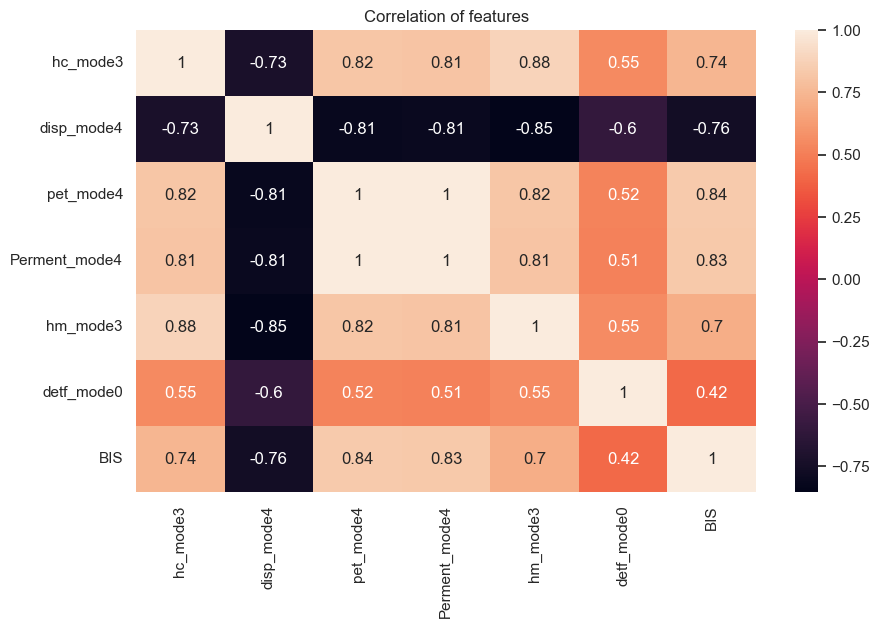

In [70]:
plt.figure(figsize=(10,6))
sns.heatmap(Pat78_data1.corr(), annot = True)
plt.title('Correlation of features')
plt.show()

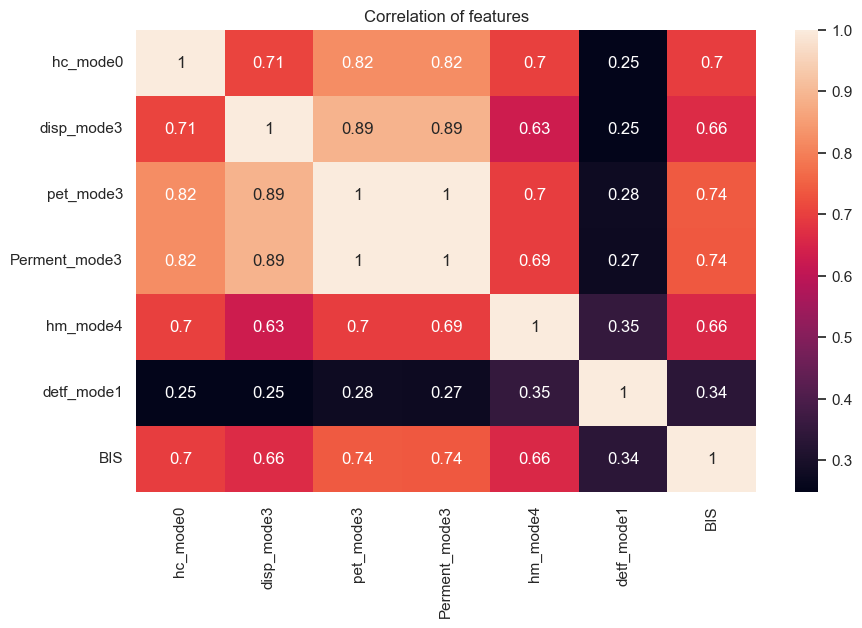

In [71]:
plt.figure(figsize=(10,6))
sns.heatmap(Pat78_data2.corr(), annot = True)
plt.title('Correlation of features')
plt.show()

In [ ]:
ant.hjorth_params